# Notebook for generating analysis and panels in Figure 7
This version does not scale the features to compare between the two datasets

In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload


import pandas as pd
import sys
#import seaborn as sns
sys.path.append('../../src')
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter

from abrTools import loadKingsData, loadSheffieldData,interFunc

fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('../..','results',str(date.today()))

if not os.path.exists(savefolder):
    os.makedirs(savefolder)

from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=45
fontSize = 54*2
import matplotlib.gridspec as gridspec

resultFolder = '../../results/2024-10-27-sheffieldvKings-unscaled'
import figureTools

Using matplotlib backend: <object object at 0x105ebe480>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def generateMaster(resultFolder,experiment='Sheffield'):
    """
    Generates a master DataFrame by collecting and processing results from the specified folder.
    Args:
        resultFolder (str): The folder containing the result files to be collected.
        experiment (str, optional): The name of the cohort. Defaults to 'Sheffield' ('Kings', 'Combined')
    Returns:
        pandas.DataFrame: A DataFrame containing the processed results with updated accuracy, precision, recall, 
                            and F1 scores, and with model names simplified.
    """
    master = at.collectResults(resultFolder,experiment,cvFoldColumn=True)

    # Convert values to percentages
    master['accuracy'] = master['accuracy']*100
    master['test_precision_scorer_avg'] = master['test_precision_scorer_avg']*100
    master['test_recall_scorer_avg'] = master['test_recall_scorer_avg']*100
    master['roc_auc_score'] = master['roc_auc_score']*100
    master['test_precision_scorer_6N'] = master['test_precision_scorer_6N']*100
    master['test_recall_scorer_6N'] = master['test_recall_scorer_6N']*100
    master['test_f1_scorer_6N'] = master['test_f1_scorer_6N']*100

    master['test_precision_scorer_Rep'] = master['test_precision_scorer_Rep']*100
    master['test_recall_scorer_Rep'] = master['test_recall_scorer_Rep']*100
    master['test_f1_scorer_Rep'] = master['test_f1_scorer_Rep']*100
    
    master.loc[master['Model']=='HiveCote Anova FS','Model'] = 'HC'
    master.loc[master['Model']=='MLP Anova FS','Model'] = 'MLP'
    master.loc[master['Model']=='SVC Anova FS','Model'] = 'SVM'
    master.loc[master['Model']=='Random Forest Anova FS','Model'] = 'RF'
    master.loc[master['Model']=='Rocket Anova FS','Model'] = 'Rckt'
    master.loc[master['Model']=='XGBOOST Anova FS','Model'] = 'XGB'
    return master

In [3]:
masterSheffield = generateMaster(resultFolder,experiment='Sheffield')
masterKings = generateMaster(resultFolder,experiment='Kings')
masterCombined = generateMaster(resultFolder,experiment='Combined')

In [4]:
masterSheffield['Set'] = 'Set1'
masterKings['Set'] = 'Set2'
masterCombined['Set'] = 'Combined'

df = pd.concat((masterSheffield,masterKings,masterCombined))

In [5]:
df['Set'] = df['Set'].astype('category')
df['Model'] = df['Model'].astype('category')

In [7]:
# Create a column for the dataset and CV fold, tereby creating a unique identifier for each split 
df['dataset_cv_split'] = df['Model'].astype(str) + '_' + df['CV_fold'].astype(str)


In [9]:
#Fit a mixed-effects linear model to the different models and datasets to check for significant differences in the metrics between the different datasets 
from statsmodels.formula.api import mixedlm


# Fit the mixed-effects model
model = mixedlm("roc_auc_score ~ Model * C(Set, Treatment('Combined'))",  # model formula with interaction term. Change the response variable as needed
                df,
                groups=df["dataset_cv_split"])  # specify CV split as random effect

# Fit the model
mixed_model_result = model.fit()

# Print the results
print(mixed_model_result.summary())

                             Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             roc_auc_score
No. Observations:             450                 Method:                         REML         
No. Groups:                   150                 Scale:                          41.7770      
Min. group size:              3                   Log-Likelihood:                 -1465.6573   
Max. group size:              3                   Converged:                      Yes          
Mean group size:              3.0                                                              
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                           89.852    1.351 6

Results: 

Recall
set1_vs_combined = 0.439
set1_vs_set2 = 0.755
set2_vs_combined = 0.278

Sensitivity
set1_vs_combined = 0.373
set1_vs_set2 = 0.624
set2_vs_combined = 0.688

Precision
set1_vs_combined = 0.182
set1_vs_set2 = 0.468
set2_vs_combined = 0.542

Roc auc score
set1_vs_combined = 0.125
set1_vs_set2 = 0.700
set2_vs_combined = 0.251


In [10]:
df.groupby(['Model','Set'])[['test_recall_scorer_6N','test_recall_scorer_Rep','test_precision_scorer_6N','roc_auc_score','accuracy','test_f1_scorer_6N']].agg([mean,std]).to_clipboard()

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_3144/2906795831.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Model','Set'])[['test_recall_scorer_6N','test_recall_scorer_Rep','test_precision_scorer_6N','roc_auc_score','accuracy','test_f1_scorer_6N']].agg([mean,std]).to_clipboard()
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_3144/2906795831.py:1: FutureWarning: The provided callable <function mean at 0x105f59750> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['Model','Set'])[['test_recall_scorer_6N','test_recall_scorer_Rep','test_precision_scorer_6N','roc_auc_score','accuracy','test_f1_scorer_6N']].agg([mean,std]).to_

In [11]:
from sklearn.preprocessing import LabelEncoder
def rand_jitter(arr):
    stdev = 0.04 #* (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def makeMetricFigure(df,metric='accuracy',le=None,ylabel='',figureSizeSF = [1,1],shift=0,ax=None,f=None,gs=None,color='k'):
    """
    Generates a figure displaying a specified metric for different models.
    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot. Must include columns 'Model' and the specified metric.
    metric (str): The metric to plot (default is 'accuracy').
    le (LabelEncoder, optional): A pre-fitted LabelEncoder for the 'Model' column. If None, a new LabelEncoder will be created and fitted.
    ylabel (str): Label for the y-axis.
    figureSizeSF (list): Scaling factors for the figure size [width, height].
    shift (int): Horizontal shift for the scatter plot points.
    ax (matplotlib.axes.Axes, optional): Axes object to draw the plot onto, if None, a new figure and axes will be created.
    f (matplotlib.figure.Figure, optional): Figure object to draw the plot onto, if None, a new figure will be created.
    gs (matplotlib.gridspec.GridSpec, optional): GridSpec object for the figure layout, if None, a new GridSpec will be created.
    color (str): Color for the scatter plot points.
    Returns:
    tuple: (ax, le, f, gs) where:
        ax (matplotlib.axes.Axes): The axes with the plot.
        le (LabelEncoder): The LabelEncoder used for the 'Model' column.
        f (matplotlib.figure.Figure): The figure object.
        gs (matplotlib.gridspec.GridSpec): The GridSpec object.
    """
    
    df2 = df.drop(['p_value','Frequency'],axis=1).groupby('Model')[[metric]].agg(('mean','std')).reset_index()
    if le is None:
        le = LabelEncoder()
        le.fit(df['Model'])
    df['Model idx'] = le.transform(df['Model'])
    df2['Model idx'] = le.transform(df2['Model'])

    if ax is None:
        f=plt.figure(figsize=(3.7*2.5*1.6138 * figureSizeSF[0],3.7*2.5*1.2* figureSizeSF[1]))
        gs= gridspec.GridSpec(1,1,hspace=0,figure=f)
        ax = plt.subplot(gs[0])
    jitterx = rand_jitter(df['Model idx'].values) +shift
    #sns.barplot(data=df,x='Model',y='accuracy',ax=ax,linewidth=3,ci='sd')
    #plt.bar(df2['Model idx'].values,df2[[('accuracy','mean')]].values.ravel())
    plt.scatter(jitterx,df[metric],s=markersize**1.85/2.5*np.mean(figureSizeSF),clip_on=False,alpha=0.2,linewidths=0)


    plt.errorbar(df2['Model idx'].values+shift,df2[[(metric,'mean')]].values.ravel(),df2[[(metric,'std')]].values.ravel(),fmt='o',markersize=markersize,clip_on=False,capsize=13,linewidth=4,capthick=4)
    #sns.swarmplot(data=df,x='Model',y='accuracy',ax=ax,linewidth=3)

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.set_xticks(np.arange(df2.shape[0]),le.inverse_transform(np.arange(6)),rotation=45)
    #ax.set_xlim(0,df2.shape[0]-1)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    ax.set_ylabel(ylabel)
    gs.tight_layout(f,rect=[0,0,1,0.95])
   # tight_layout()

    return ax,le,f,gs

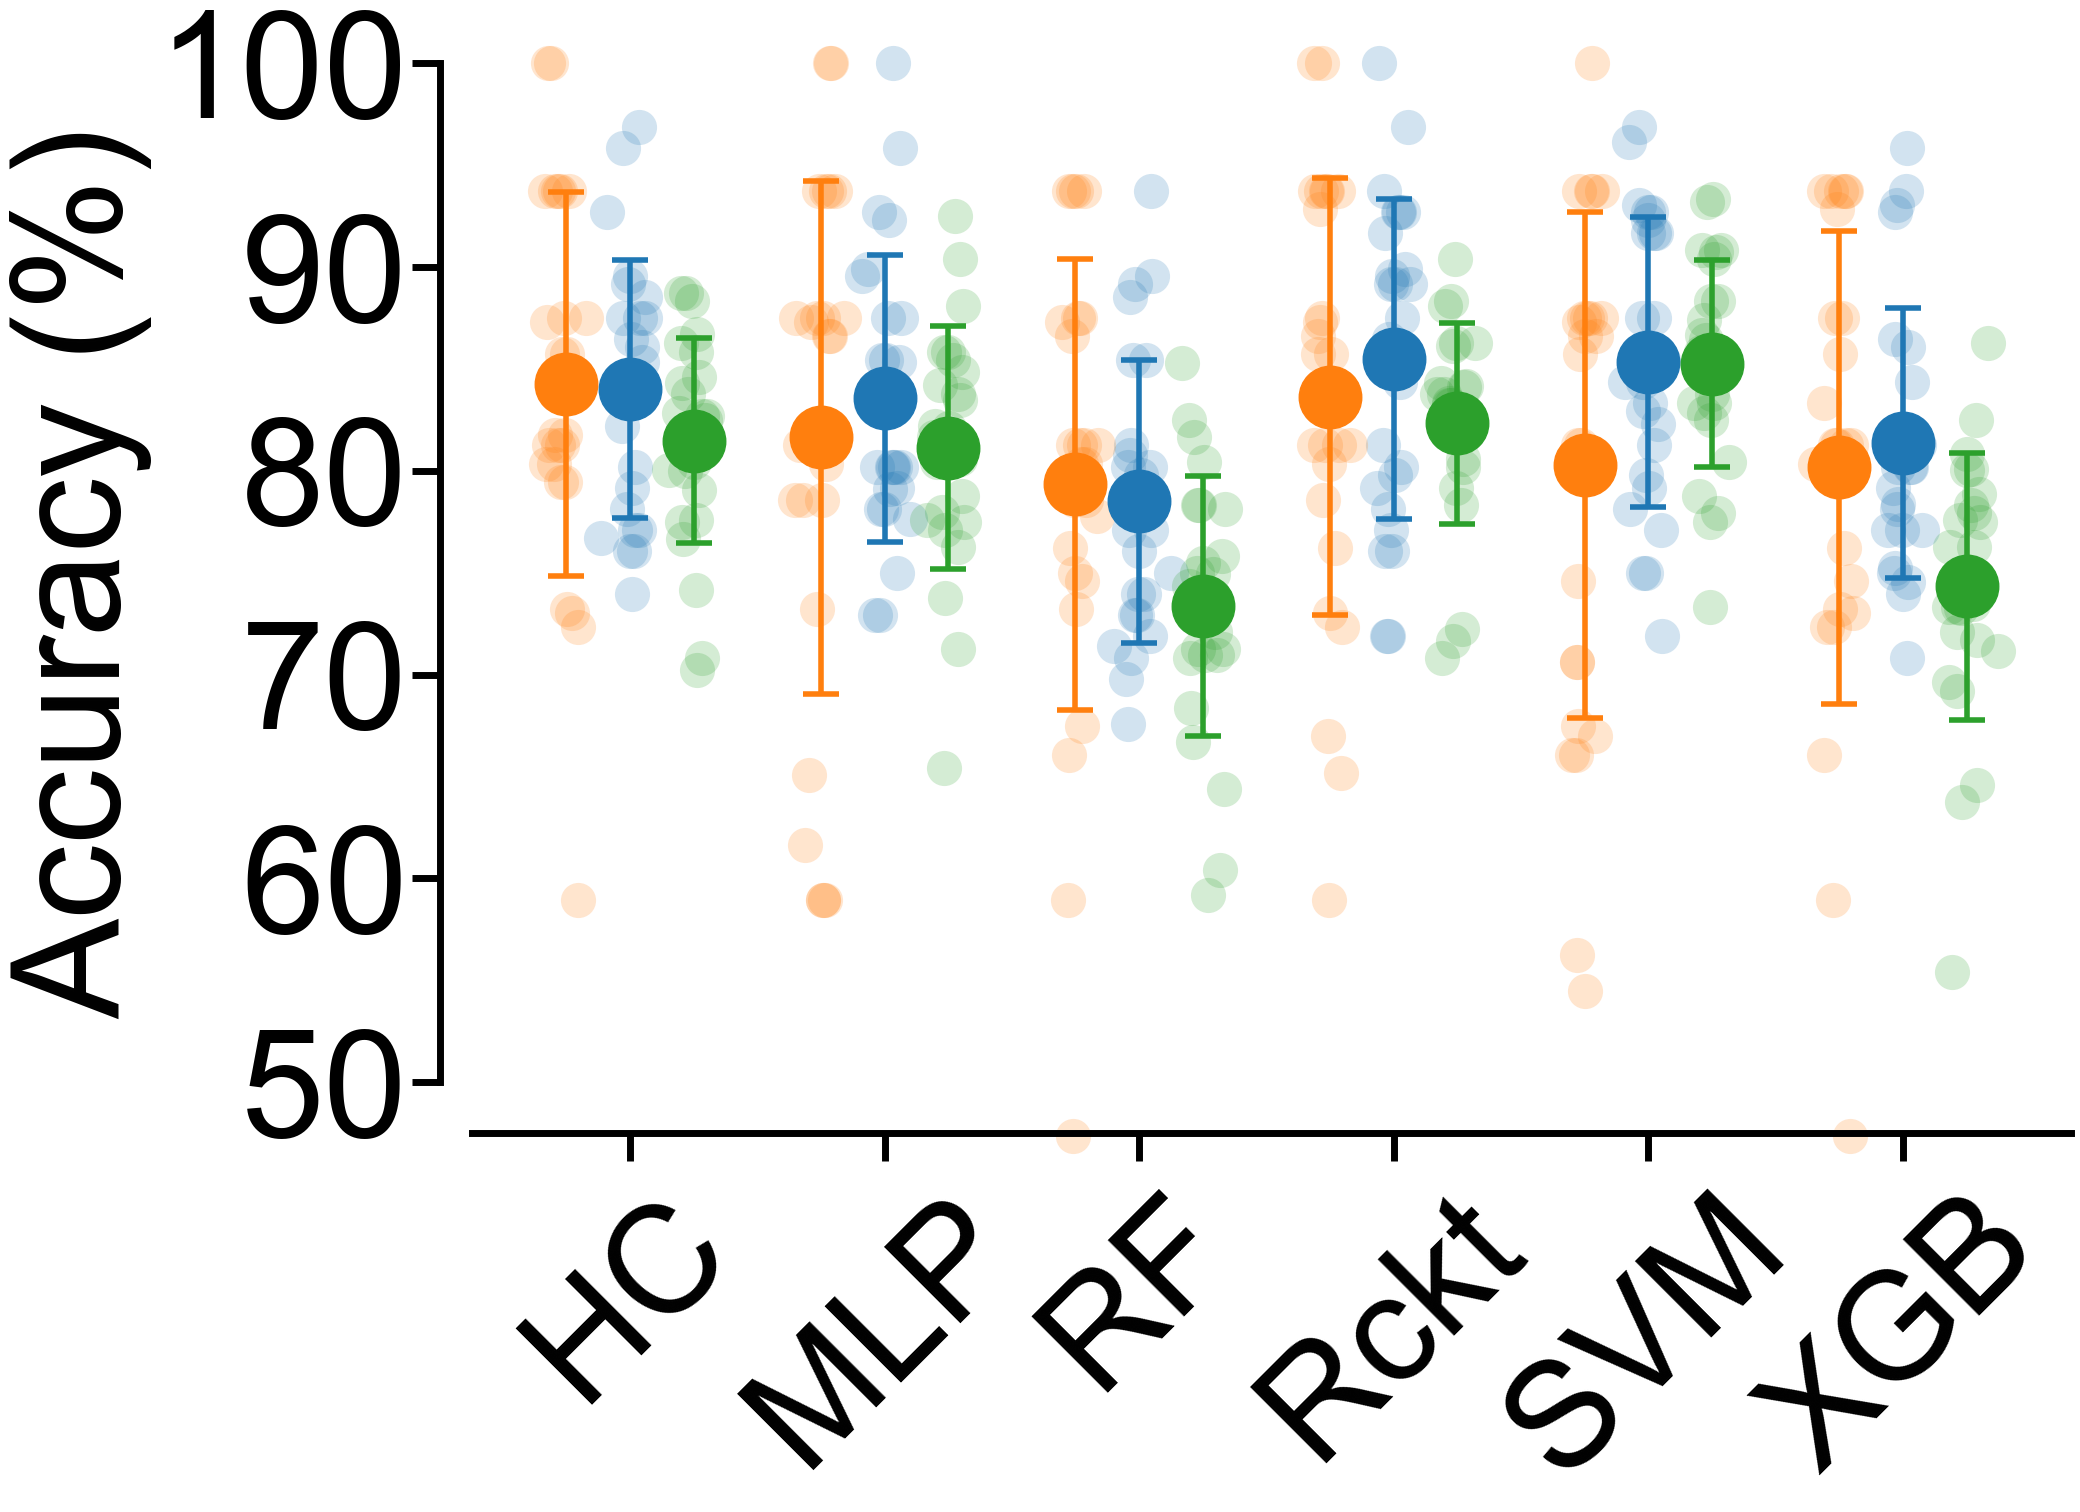

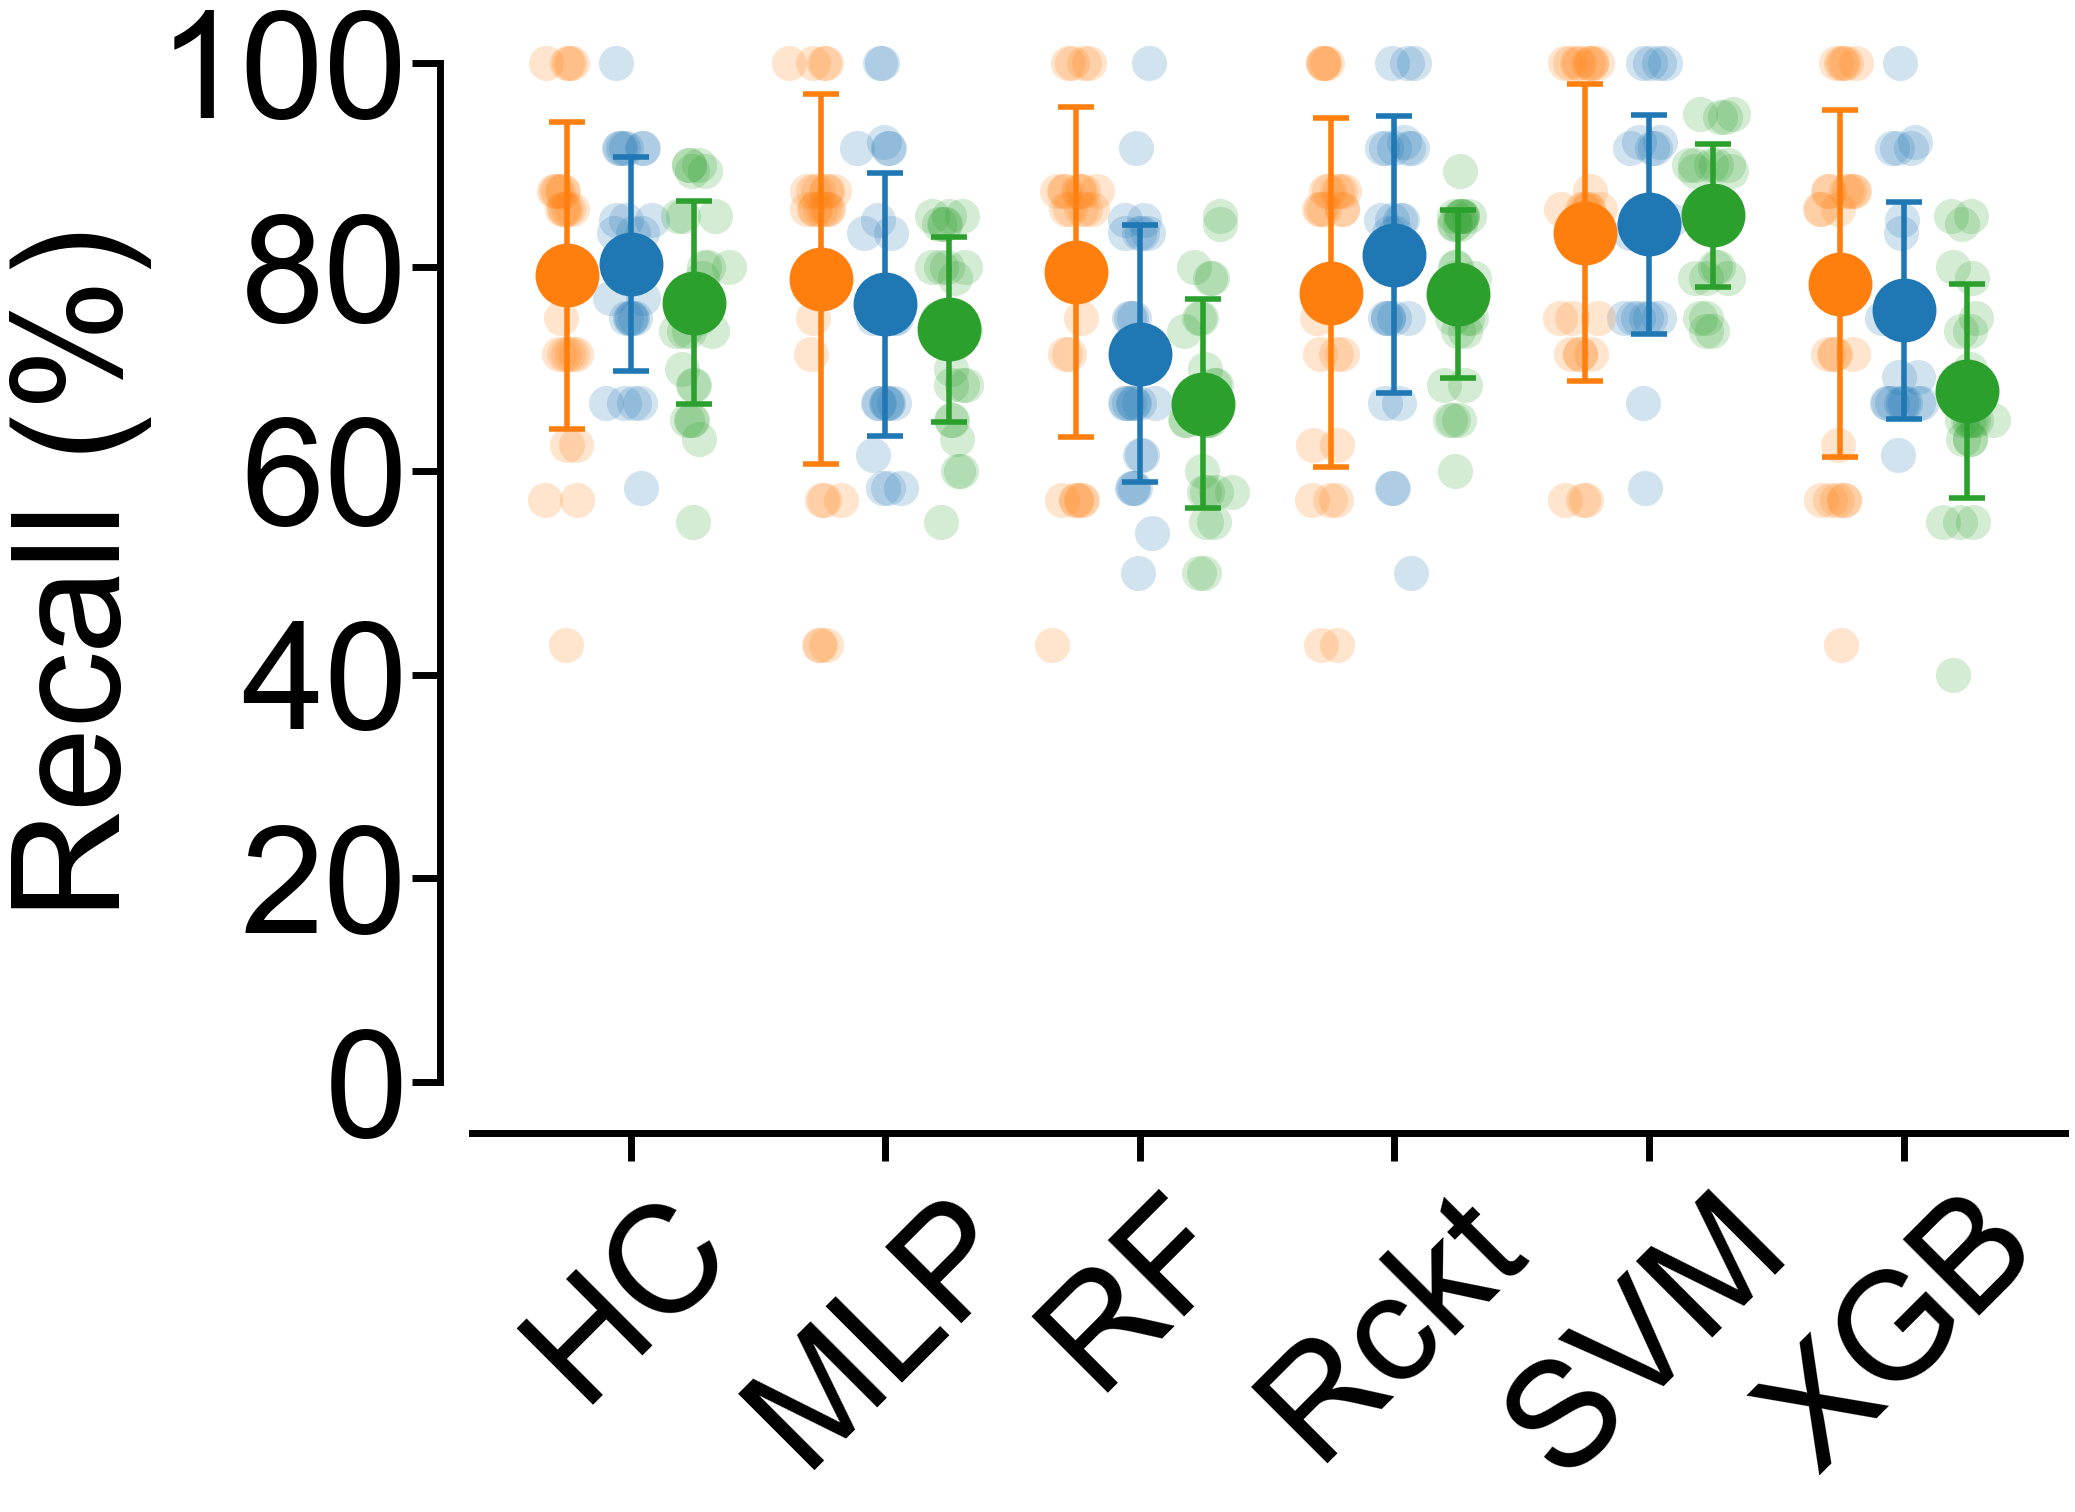

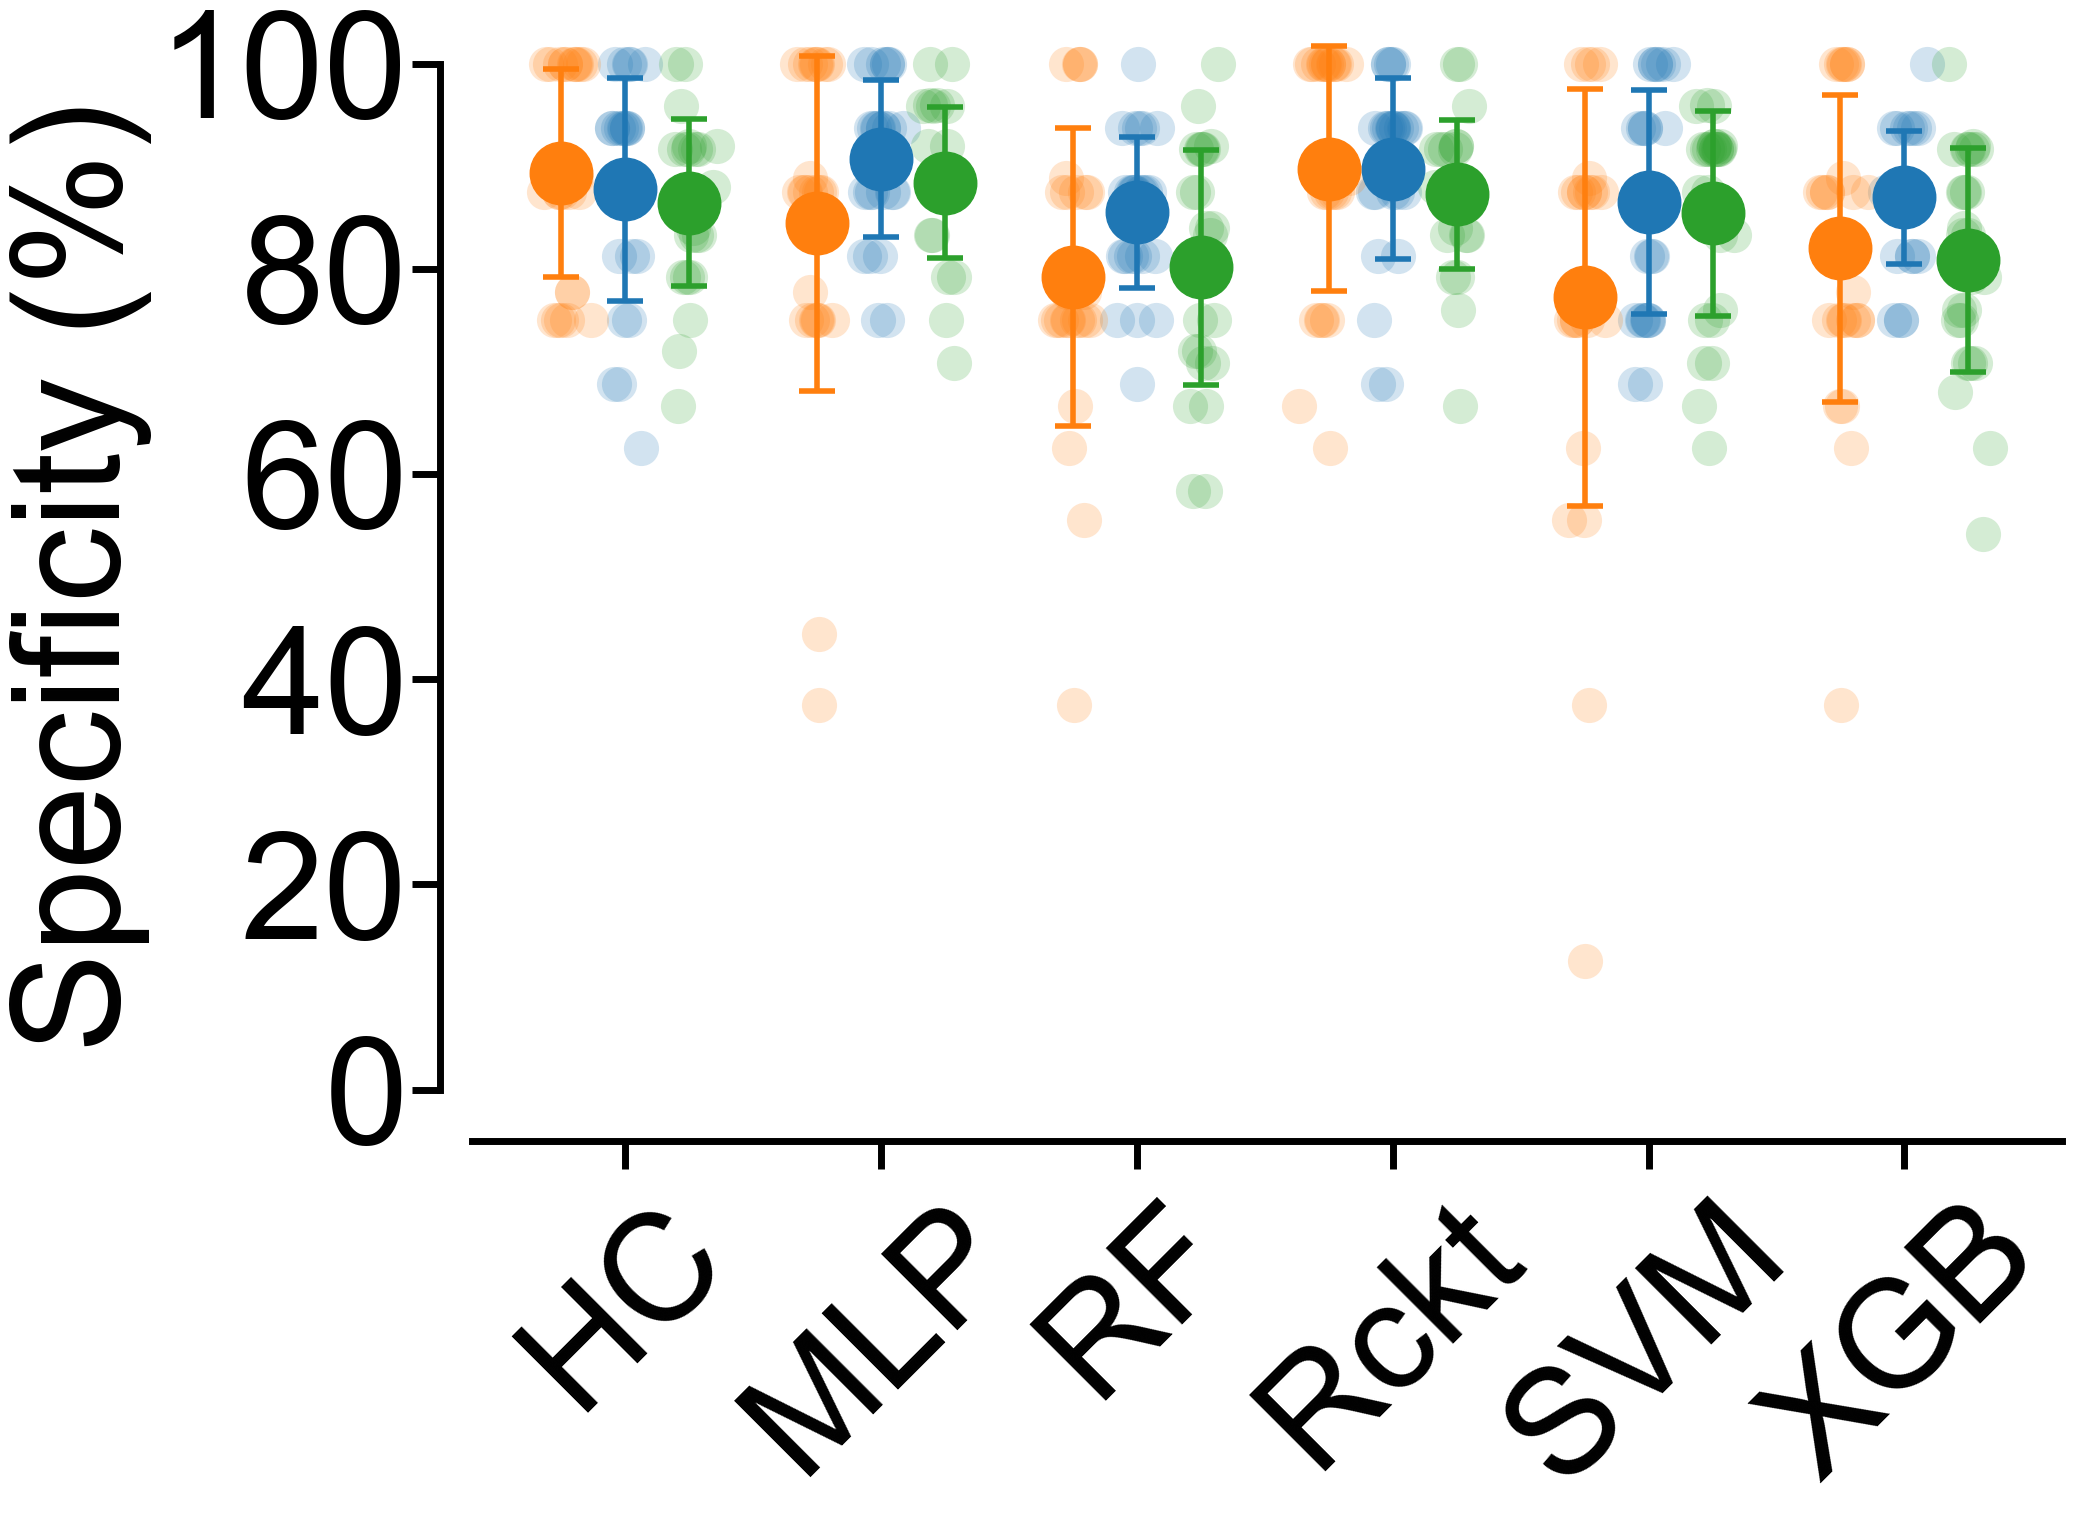

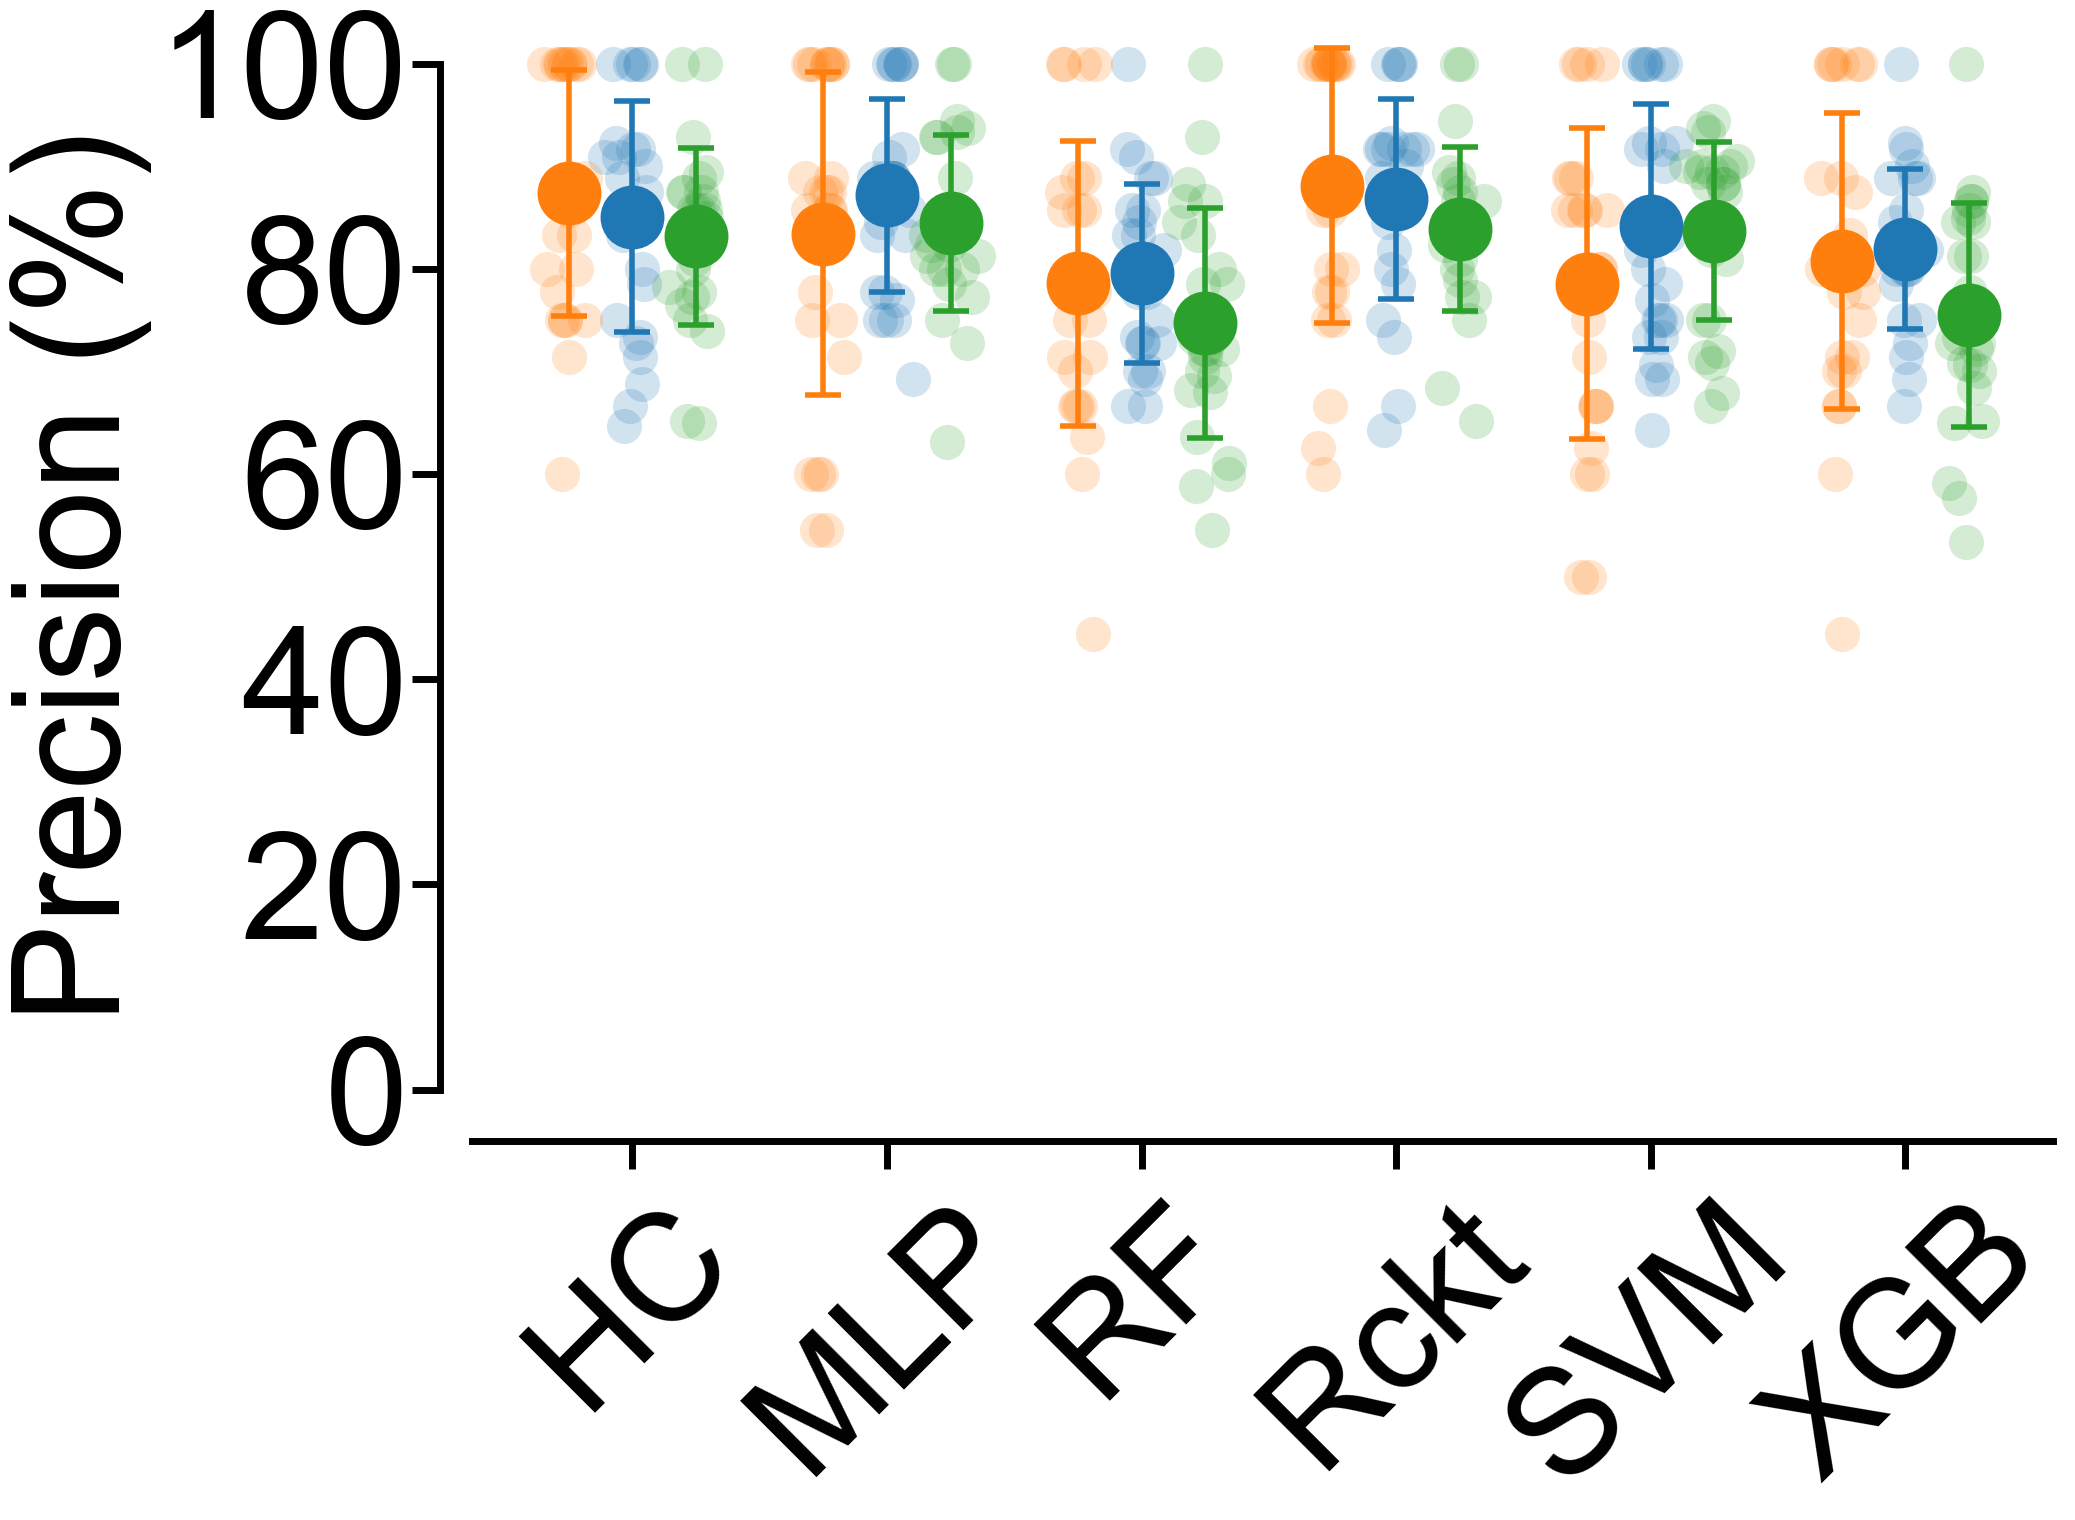

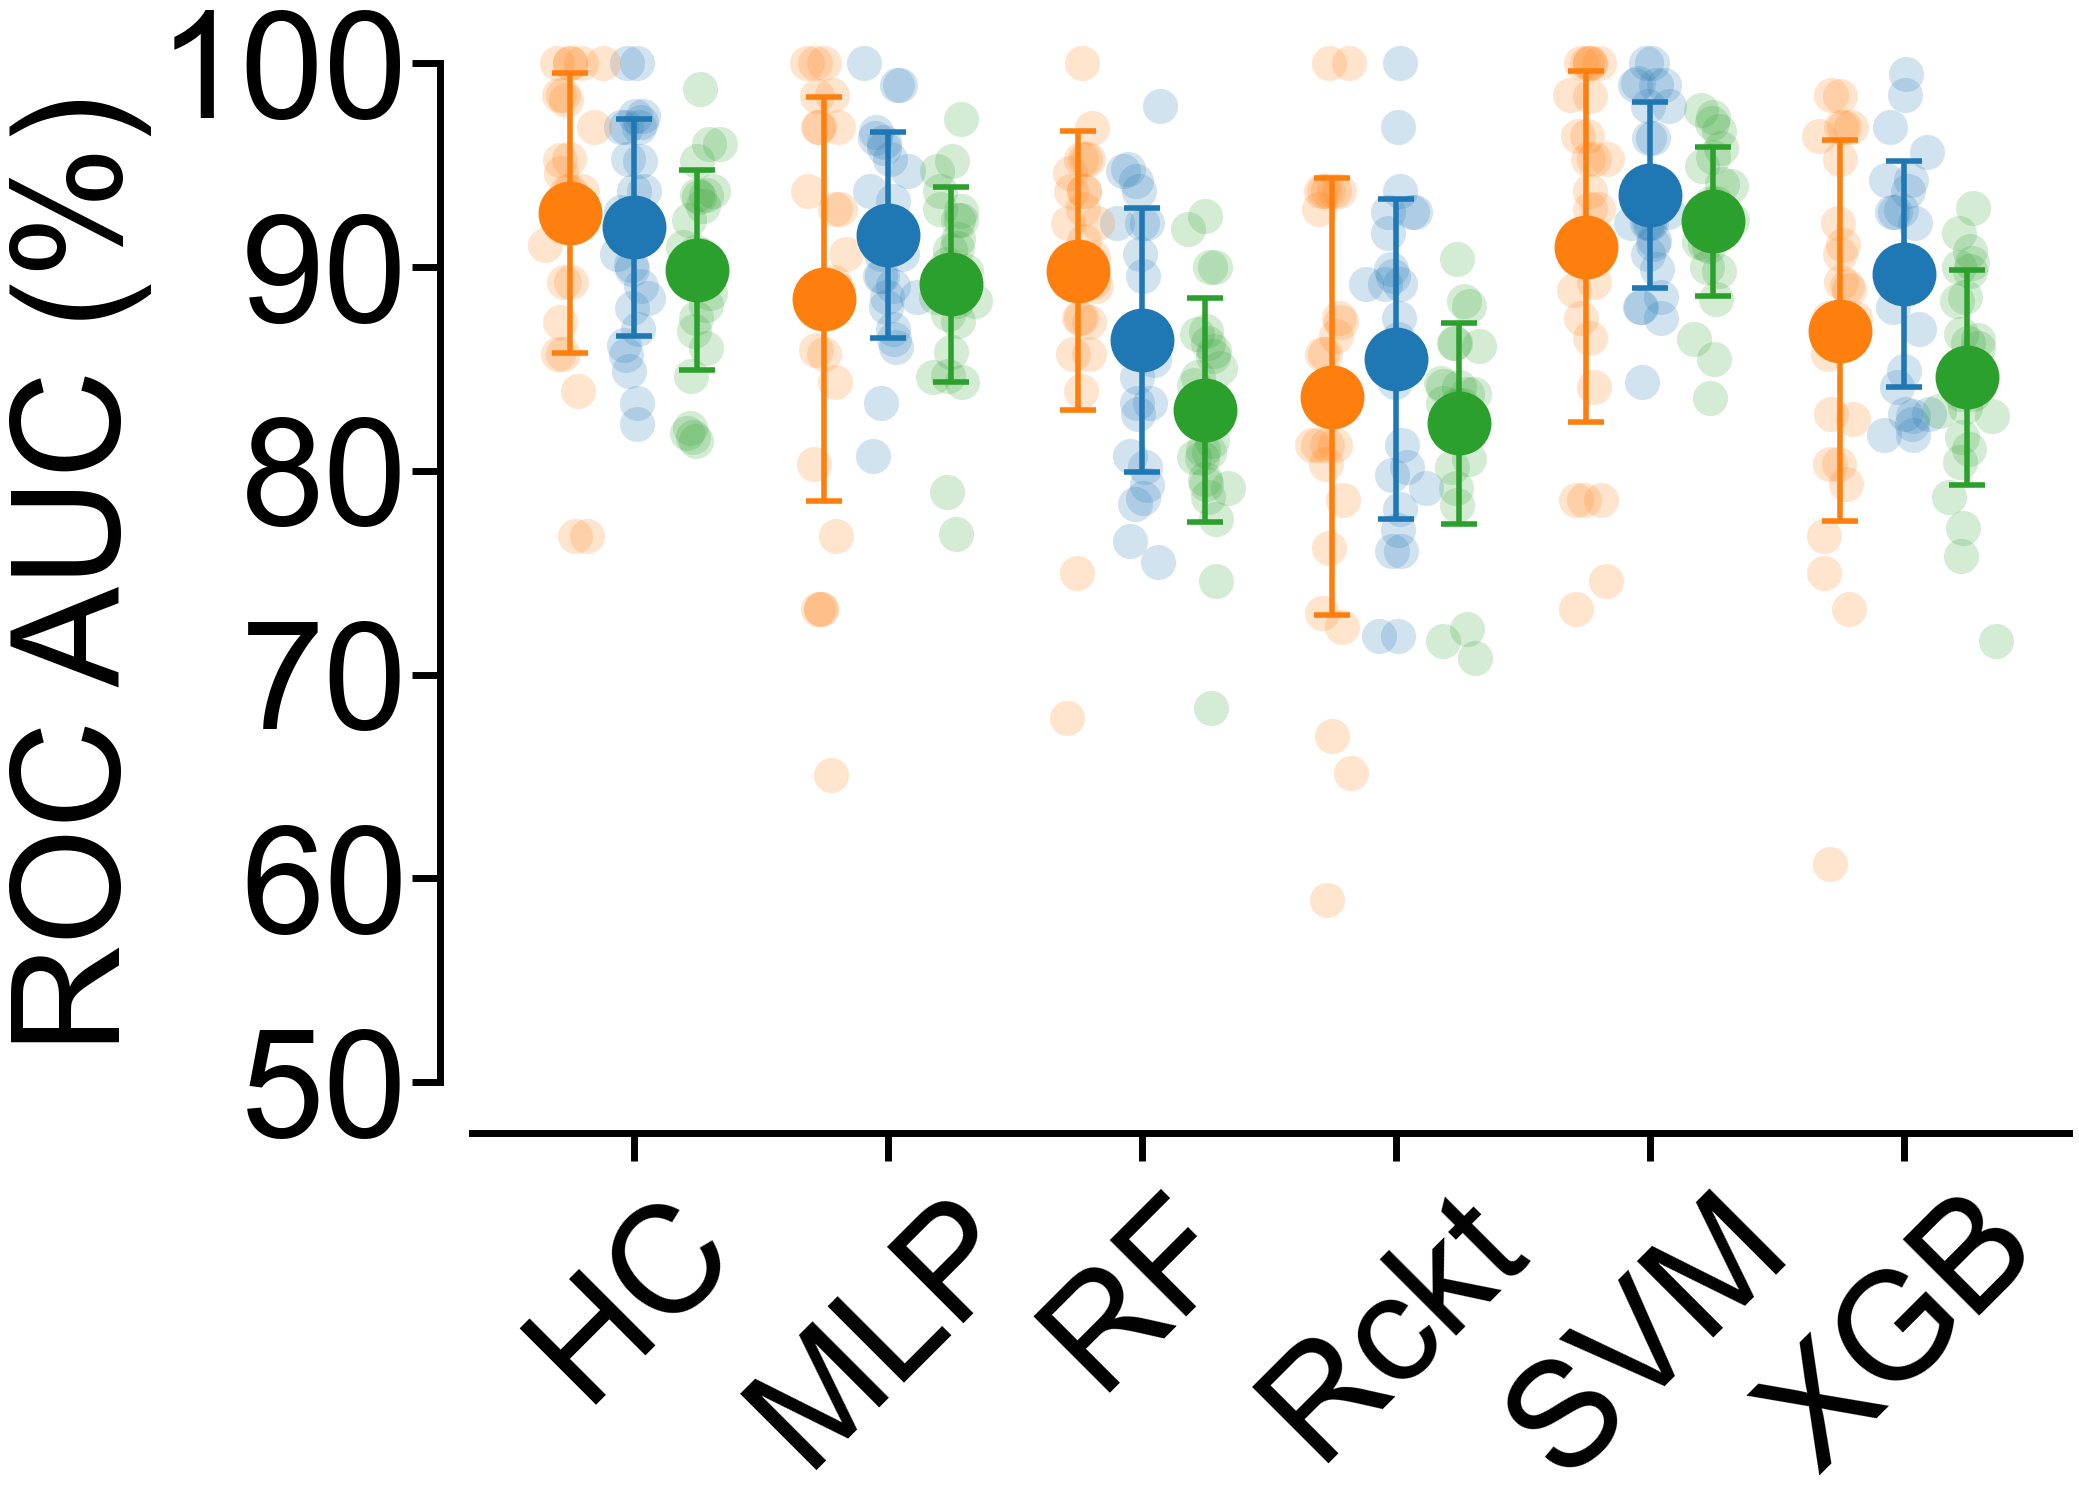

In [13]:
# Plot all the metrics


df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)
df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(50,100)
# ax.text(-0.5,60,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,56,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,52,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_accuracy_non_scaled.pdf',dpi=1200)


df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_6N',ylabel='Recall (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_6N',ylabel='Recall (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_6N',ylabel='Recall (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(0,100)
# ax.text(-0.5,18,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,10,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,2,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_recall_non_scaled.pdf',dpi=1200)


df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_Rep',ylabel='Specificity (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_Rep',ylabel='Specificity (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_recall_scorer_Rep',ylabel='Specificity (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(0,100)
# ax.text(-0.5,18,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,10,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,2,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_specificity_non_scaled.pdf',dpi=1200)




df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_precision_scorer_6N',ylabel='Precision (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_precision_scorer_6N',ylabel='Precision (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'test_precision_scorer_6N',ylabel='Precision (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(0,100)
# ax.text(-0.5,18,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,10,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,2,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_precision_non_scaled.pdf',dpi=1200)


df = masterKings[masterKings['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'roc_auc_score',ylabel='ROC AUC (%)',figureSizeSF=[1.4,1.4])
df = masterSheffield[masterSheffield['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'roc_auc_score',ylabel='ROC AUC (%)',figureSizeSF=[1.4,1.4],shift=-0.25,ax=ax,le=le,f=f,gs=gs)

df = masterCombined[masterCombined['Frequency']=='Click']
ax,le,f,gs= makeMetricFigure(df,'roc_auc_score',ylabel='ROC AUC (%)',figureSizeSF=[1.4,1.4],shift=+0.25,ax=ax,le=le,f=f,gs=gs)
ax.set_ylim(50,100)
# ax.text(-0.5,60,'Set 1',fontsize=fontSize,color=np.array([239,134,54])/255)
# ax.text(-0.5,56,'Set 2',fontsize=fontSize,color=np.array([59,117,175])/255)
# ax.text(-0.5,52,'Combined',fontsize=fontSize,color=np.array([81,158,62])/255)
f.savefig('./Panels/kingsvSheffield_rocauc_non_scaled.pdf',dpi=1200)




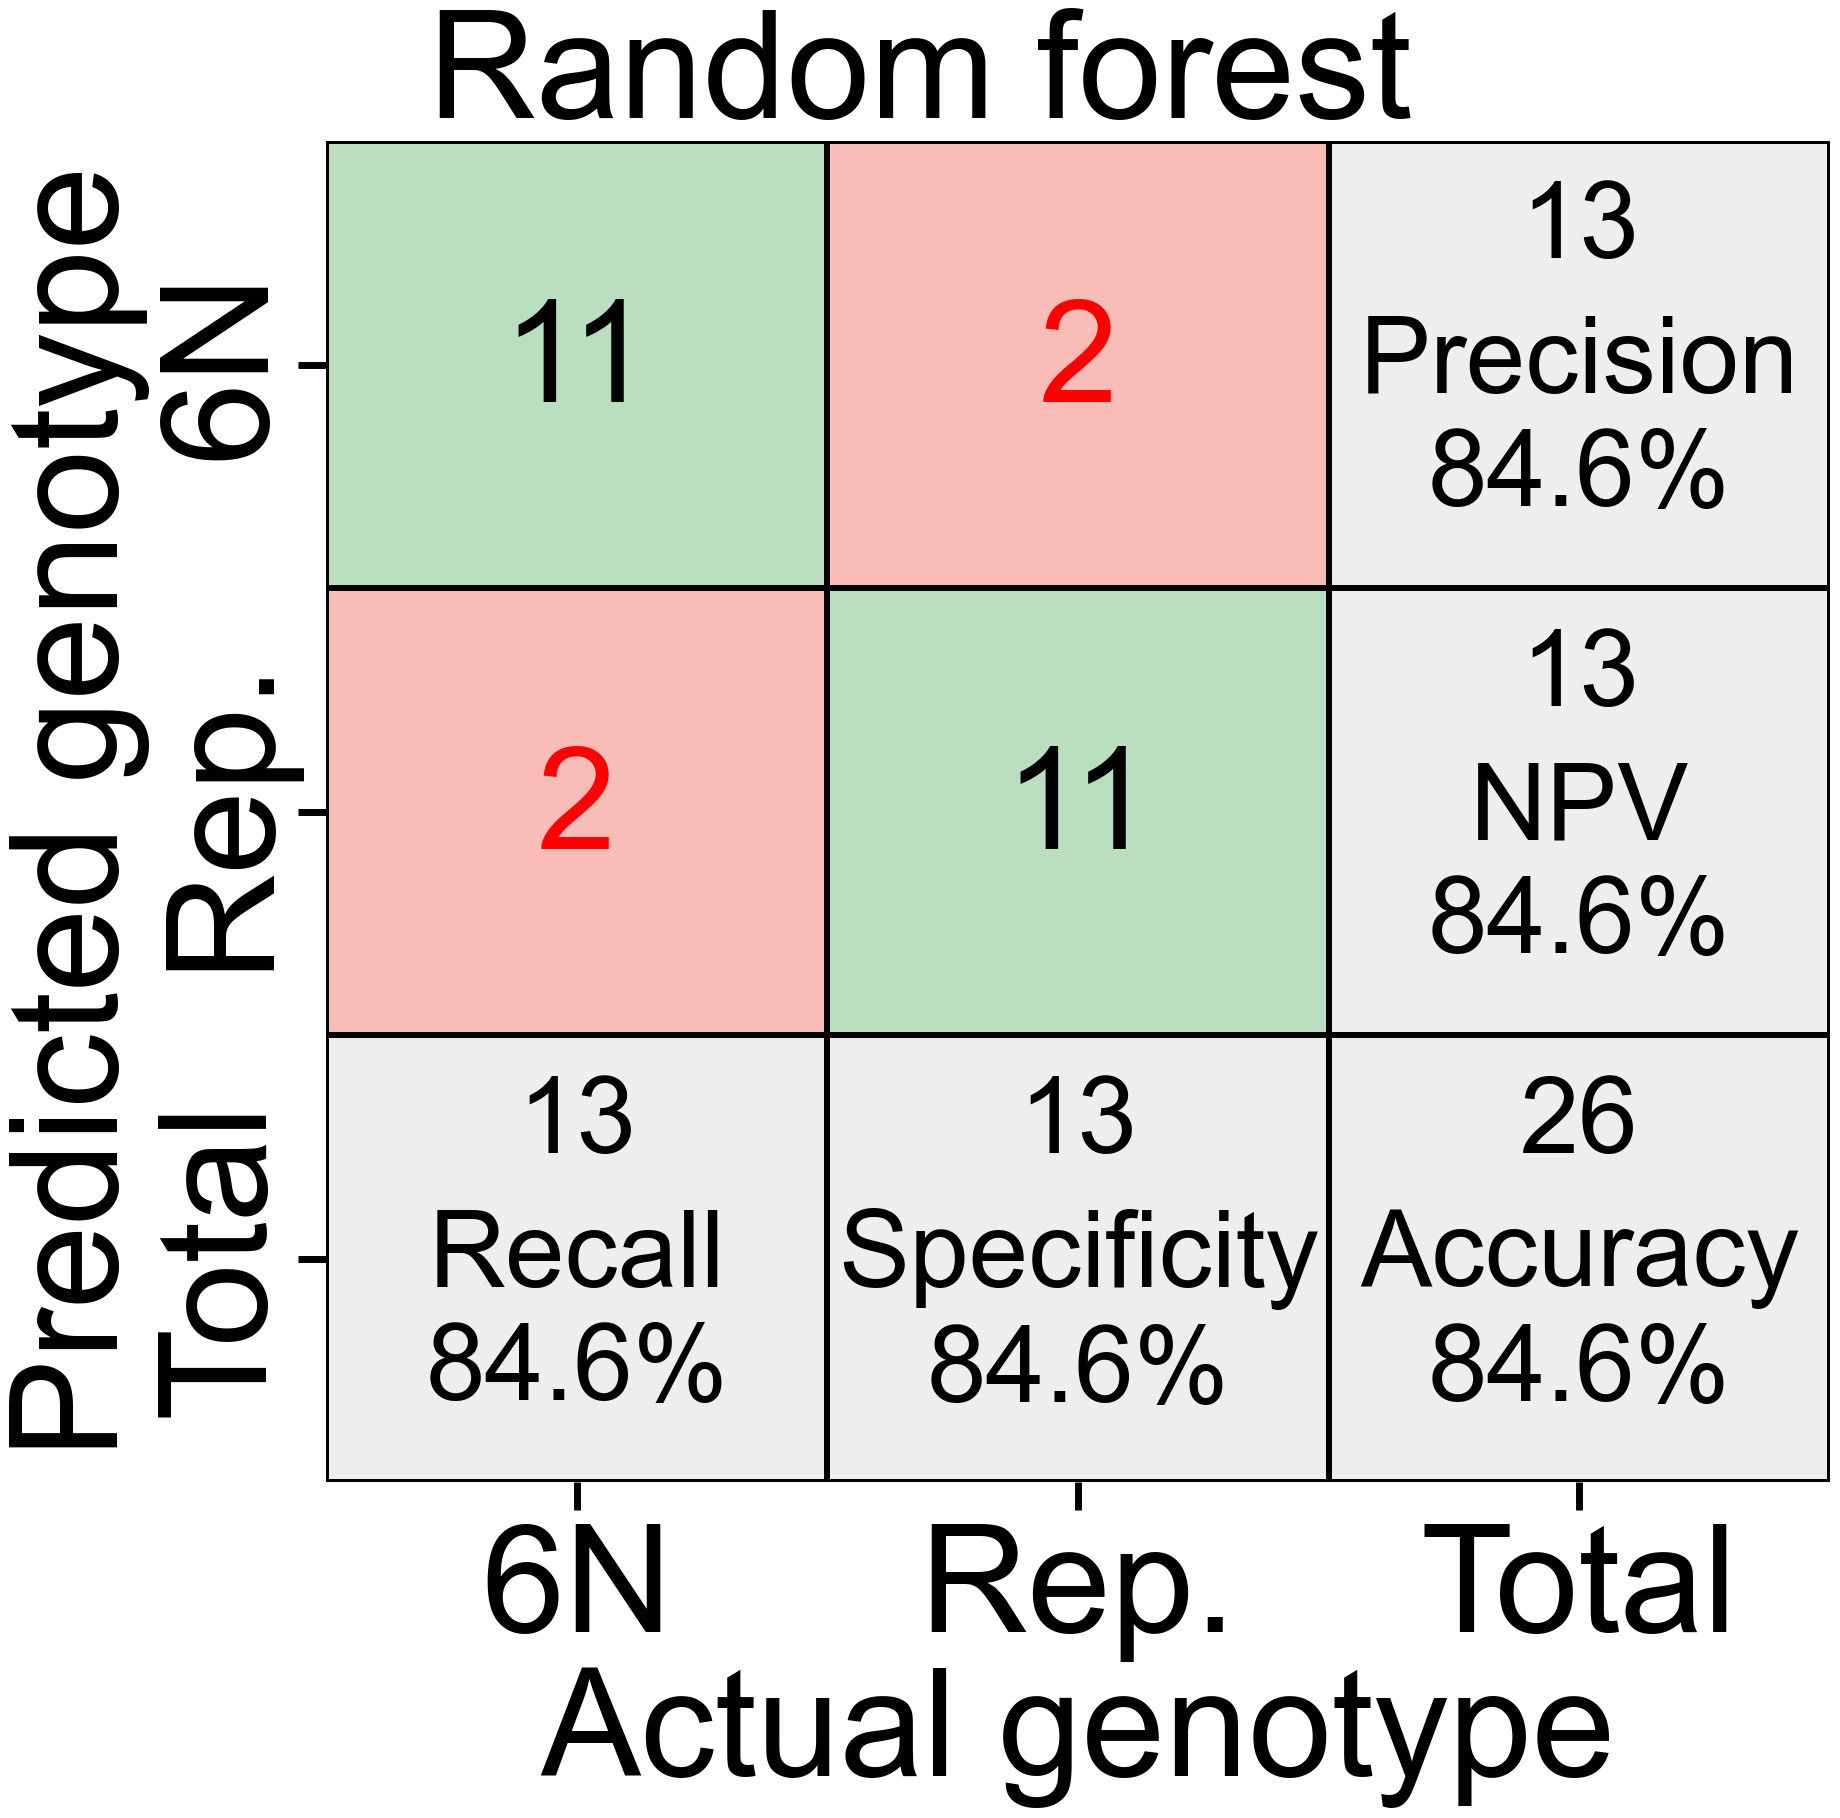

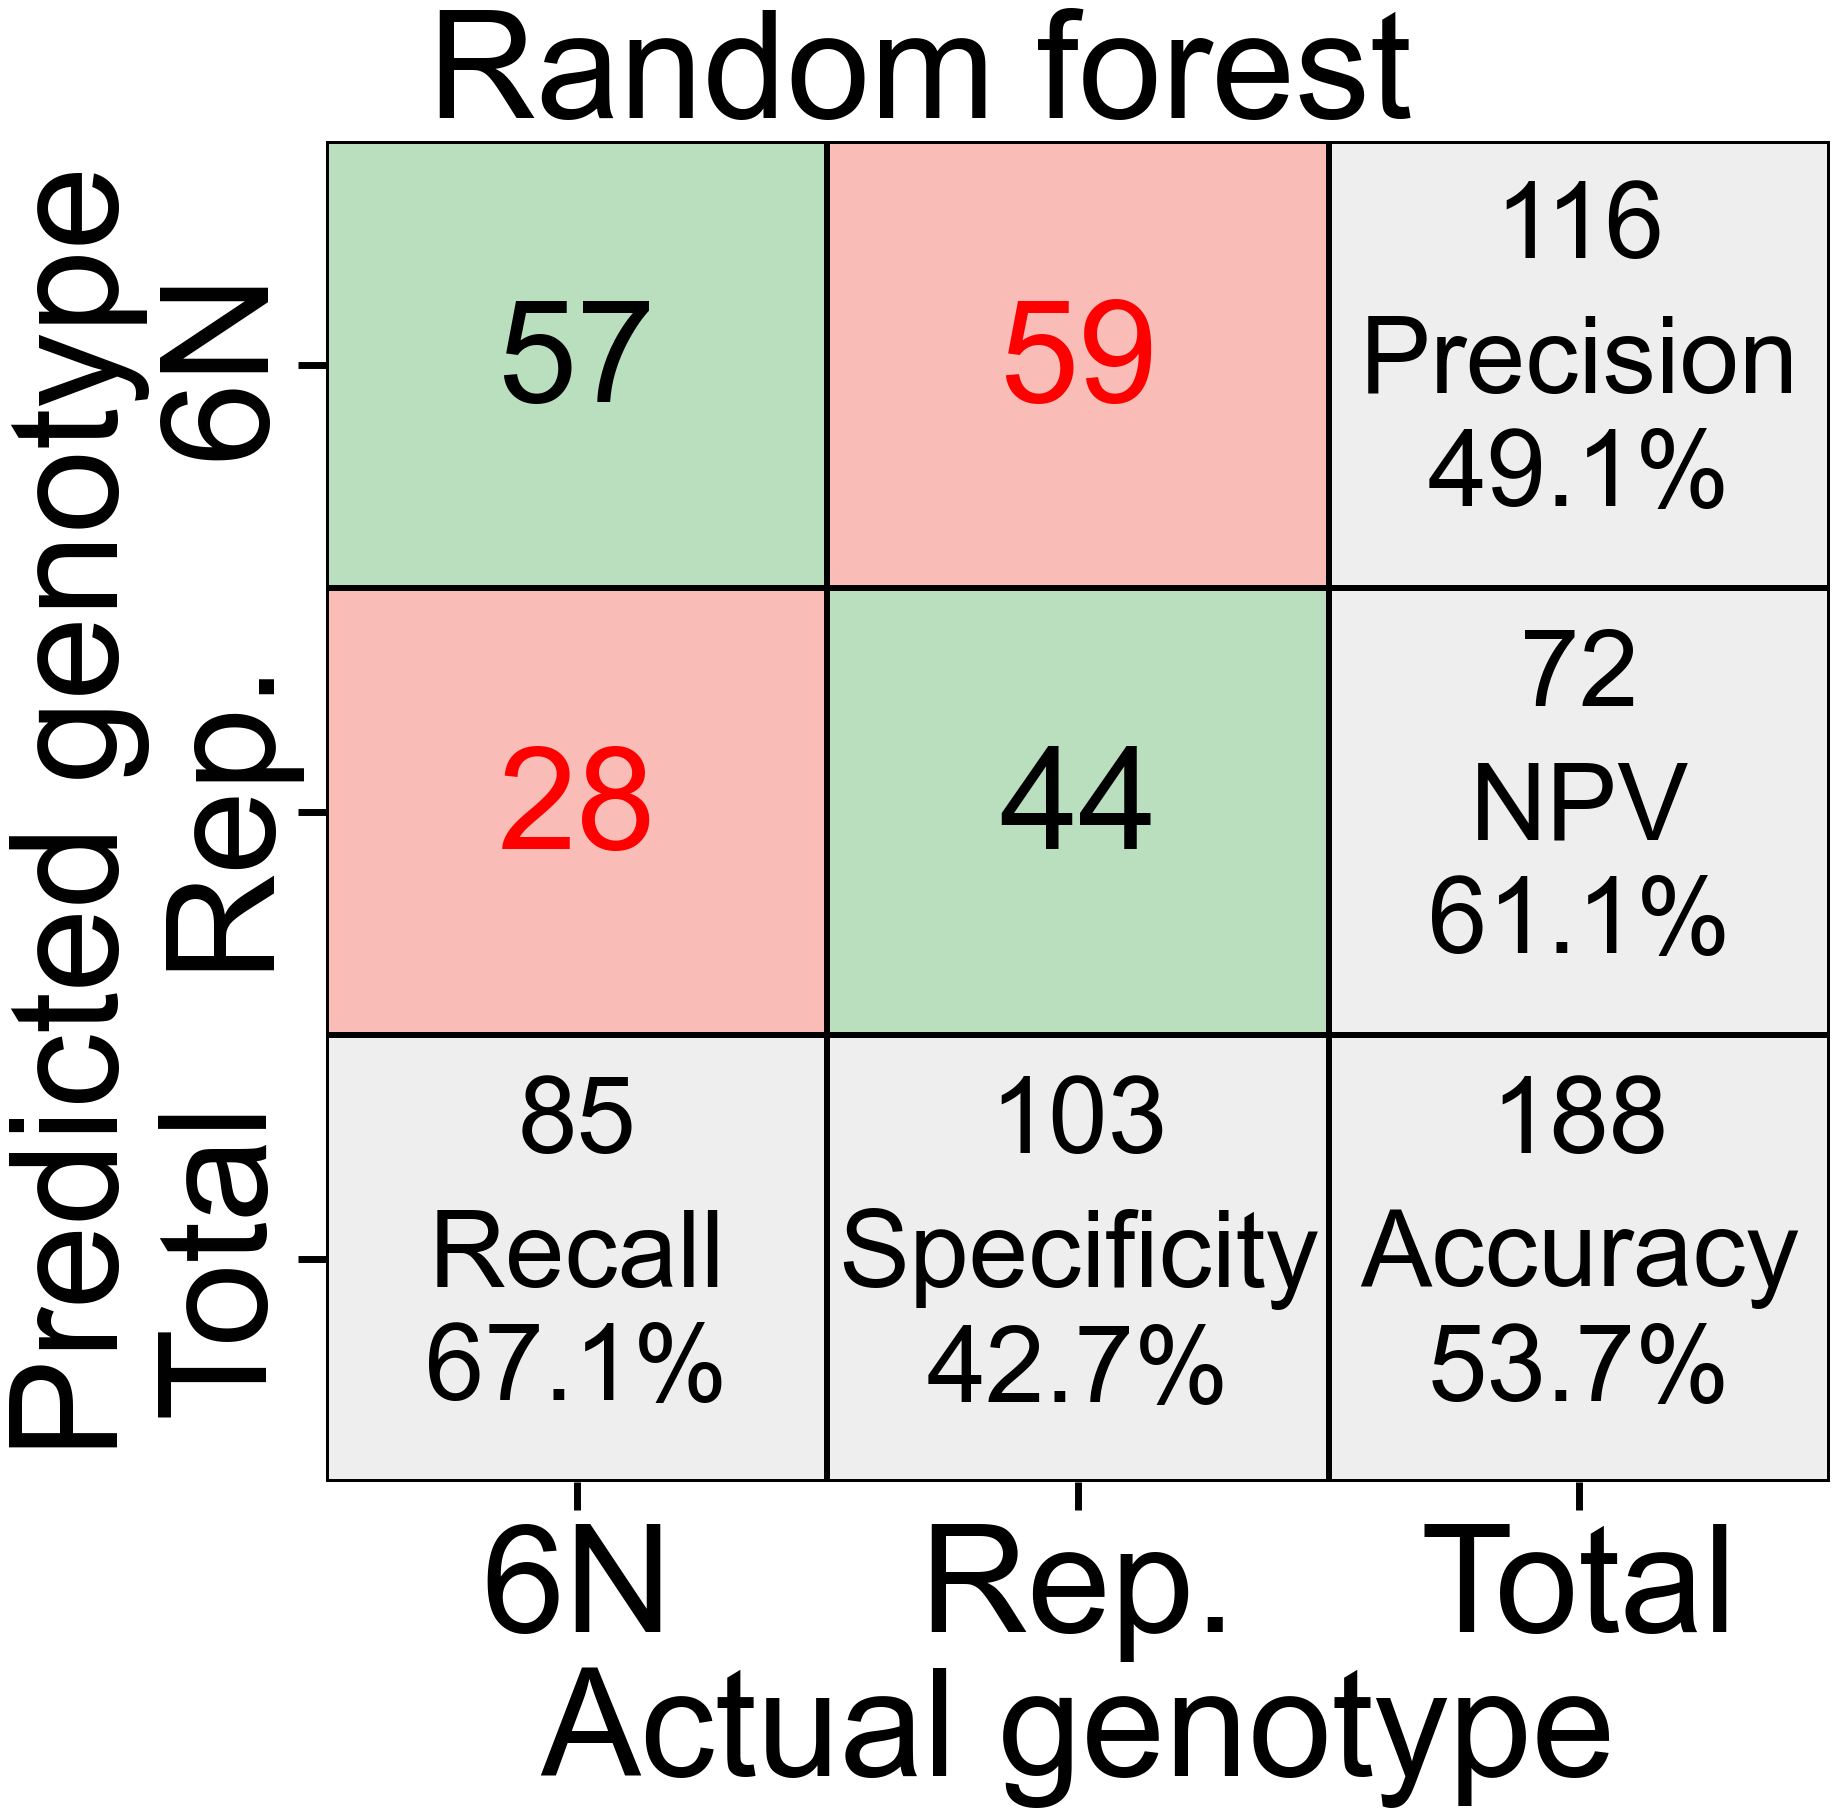

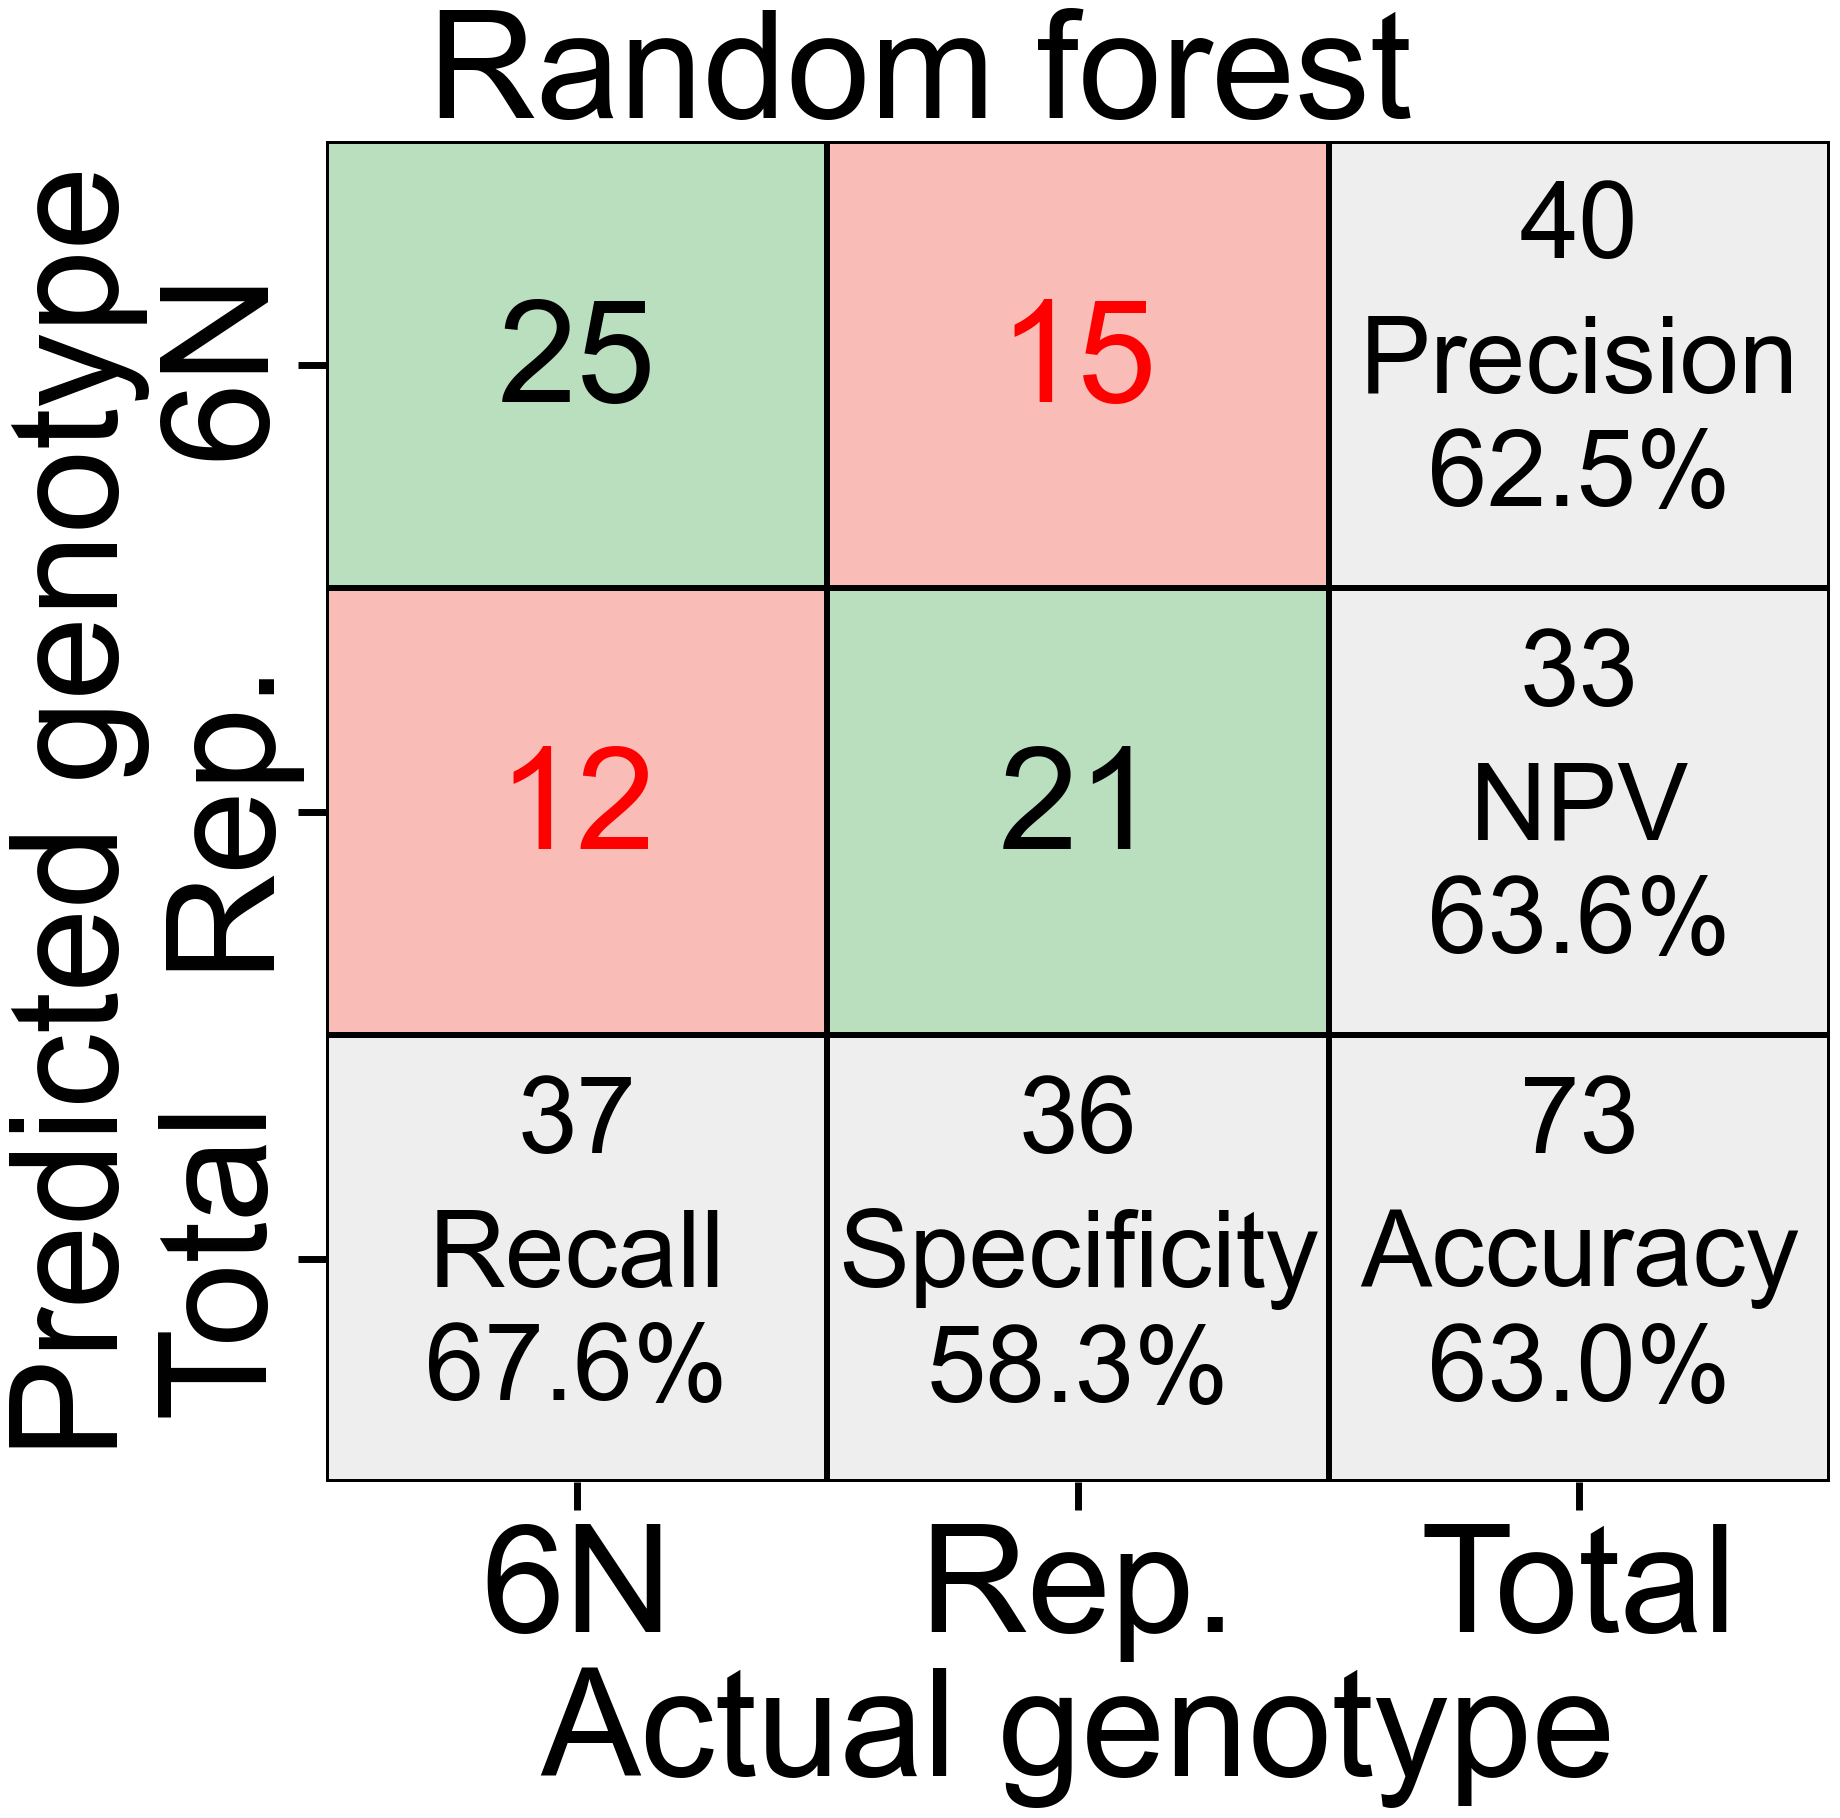

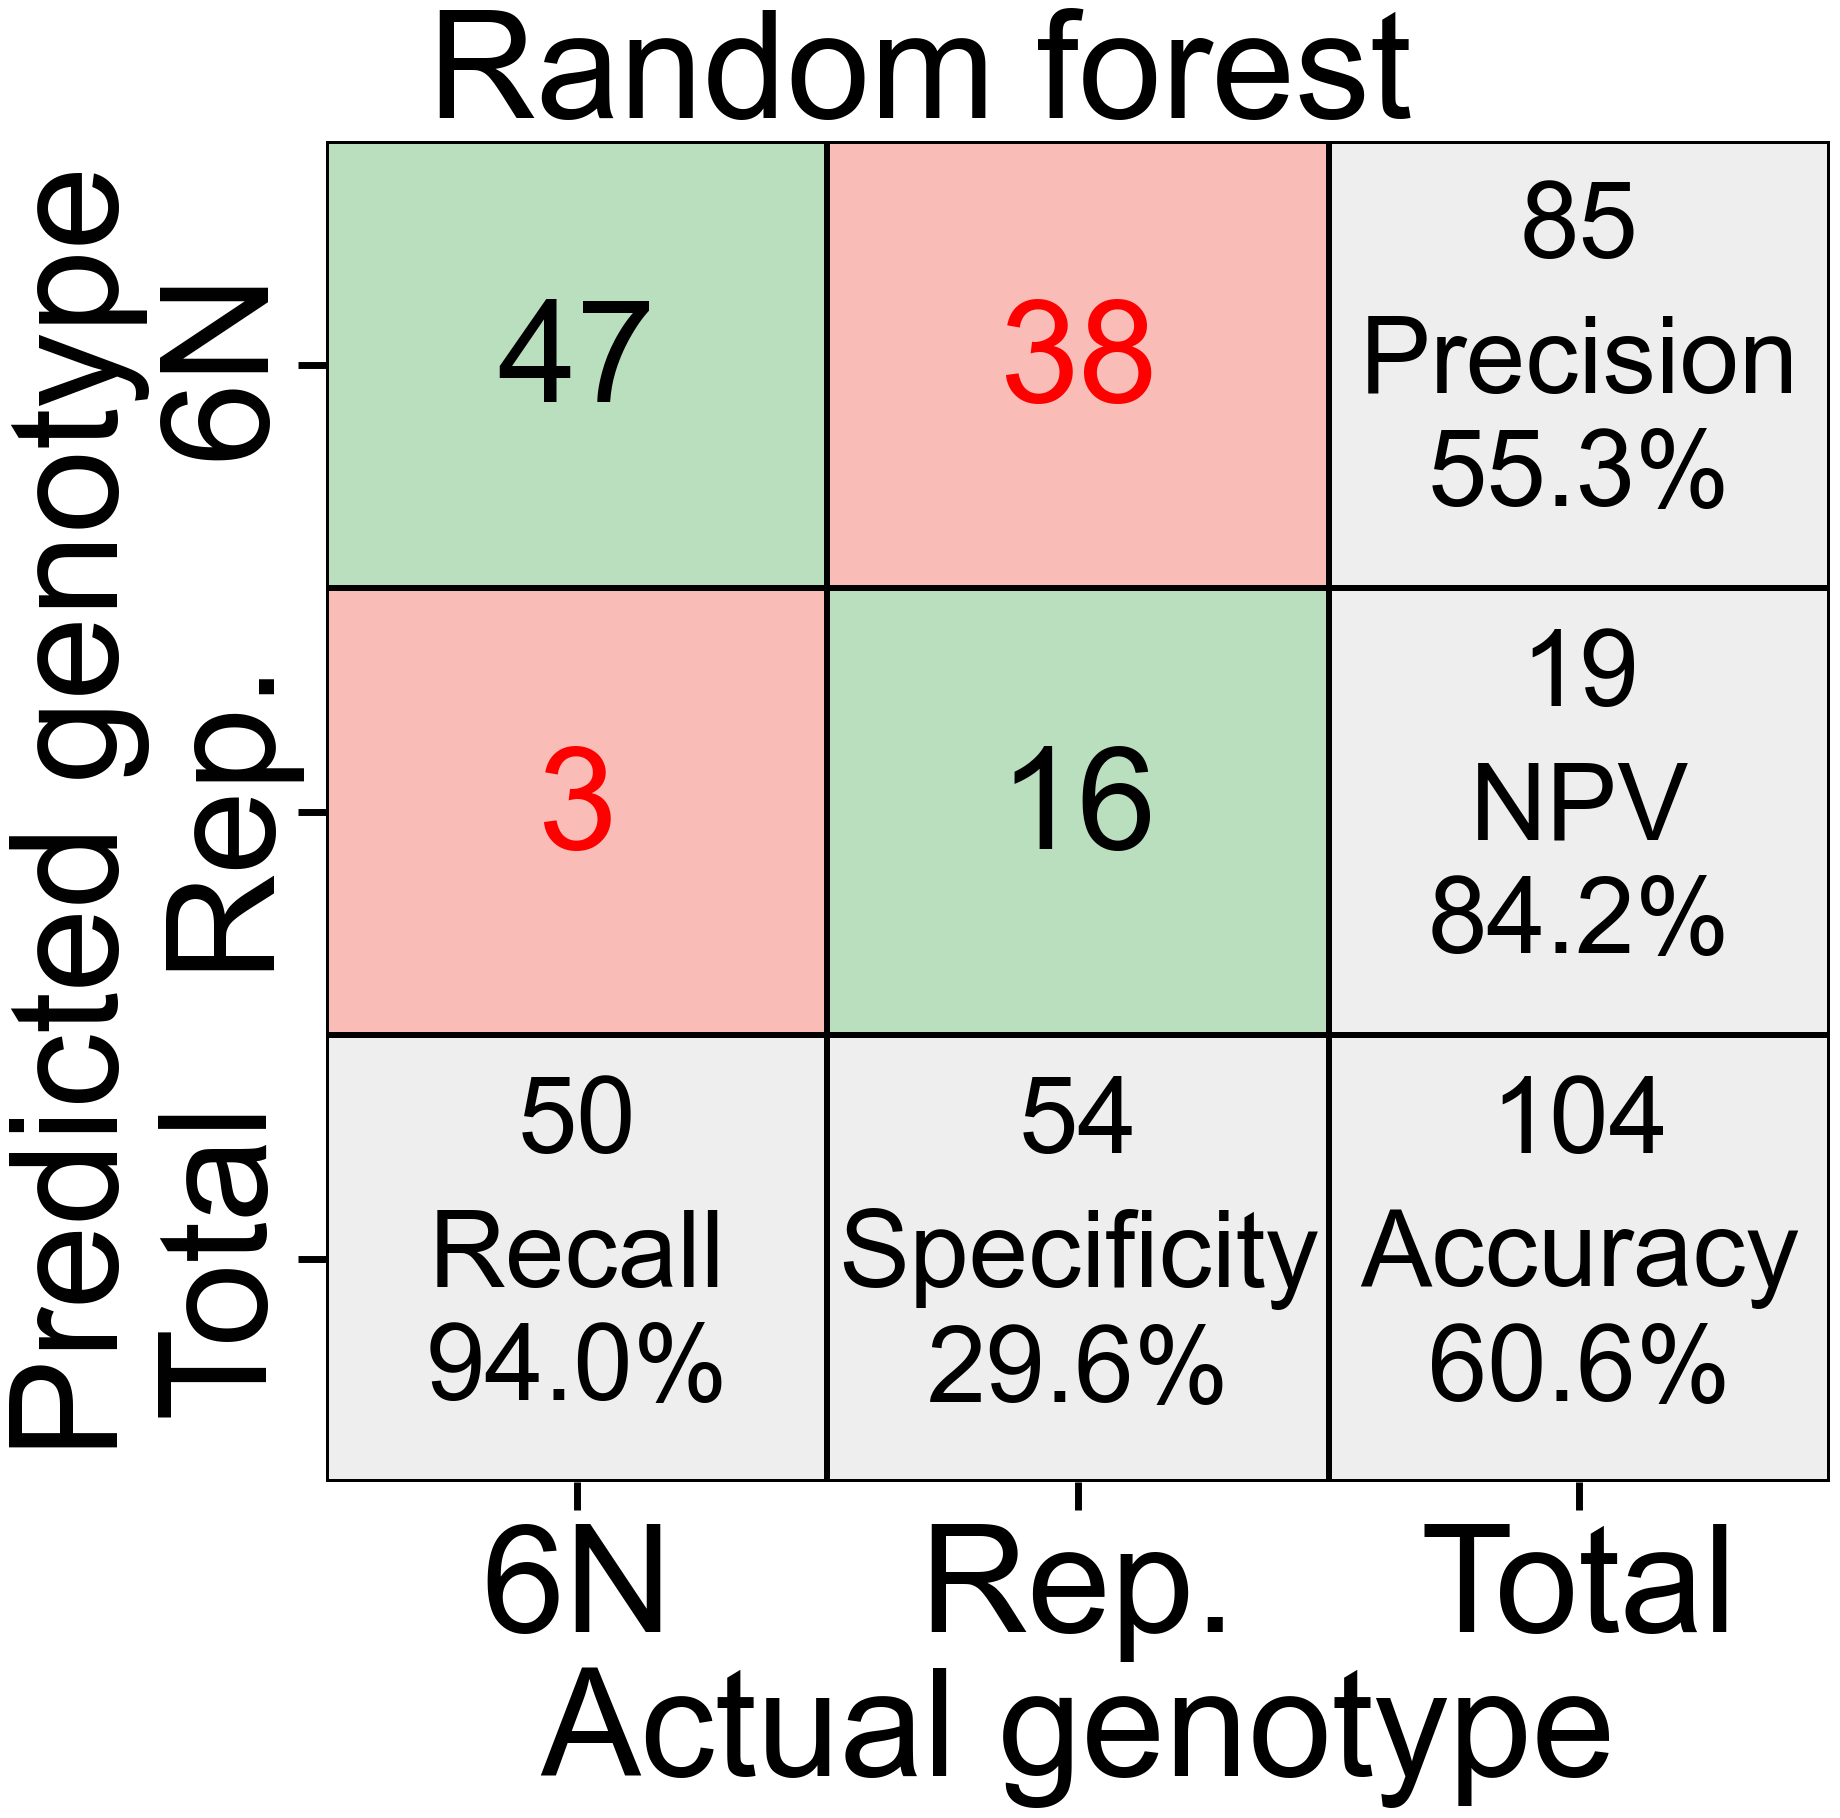

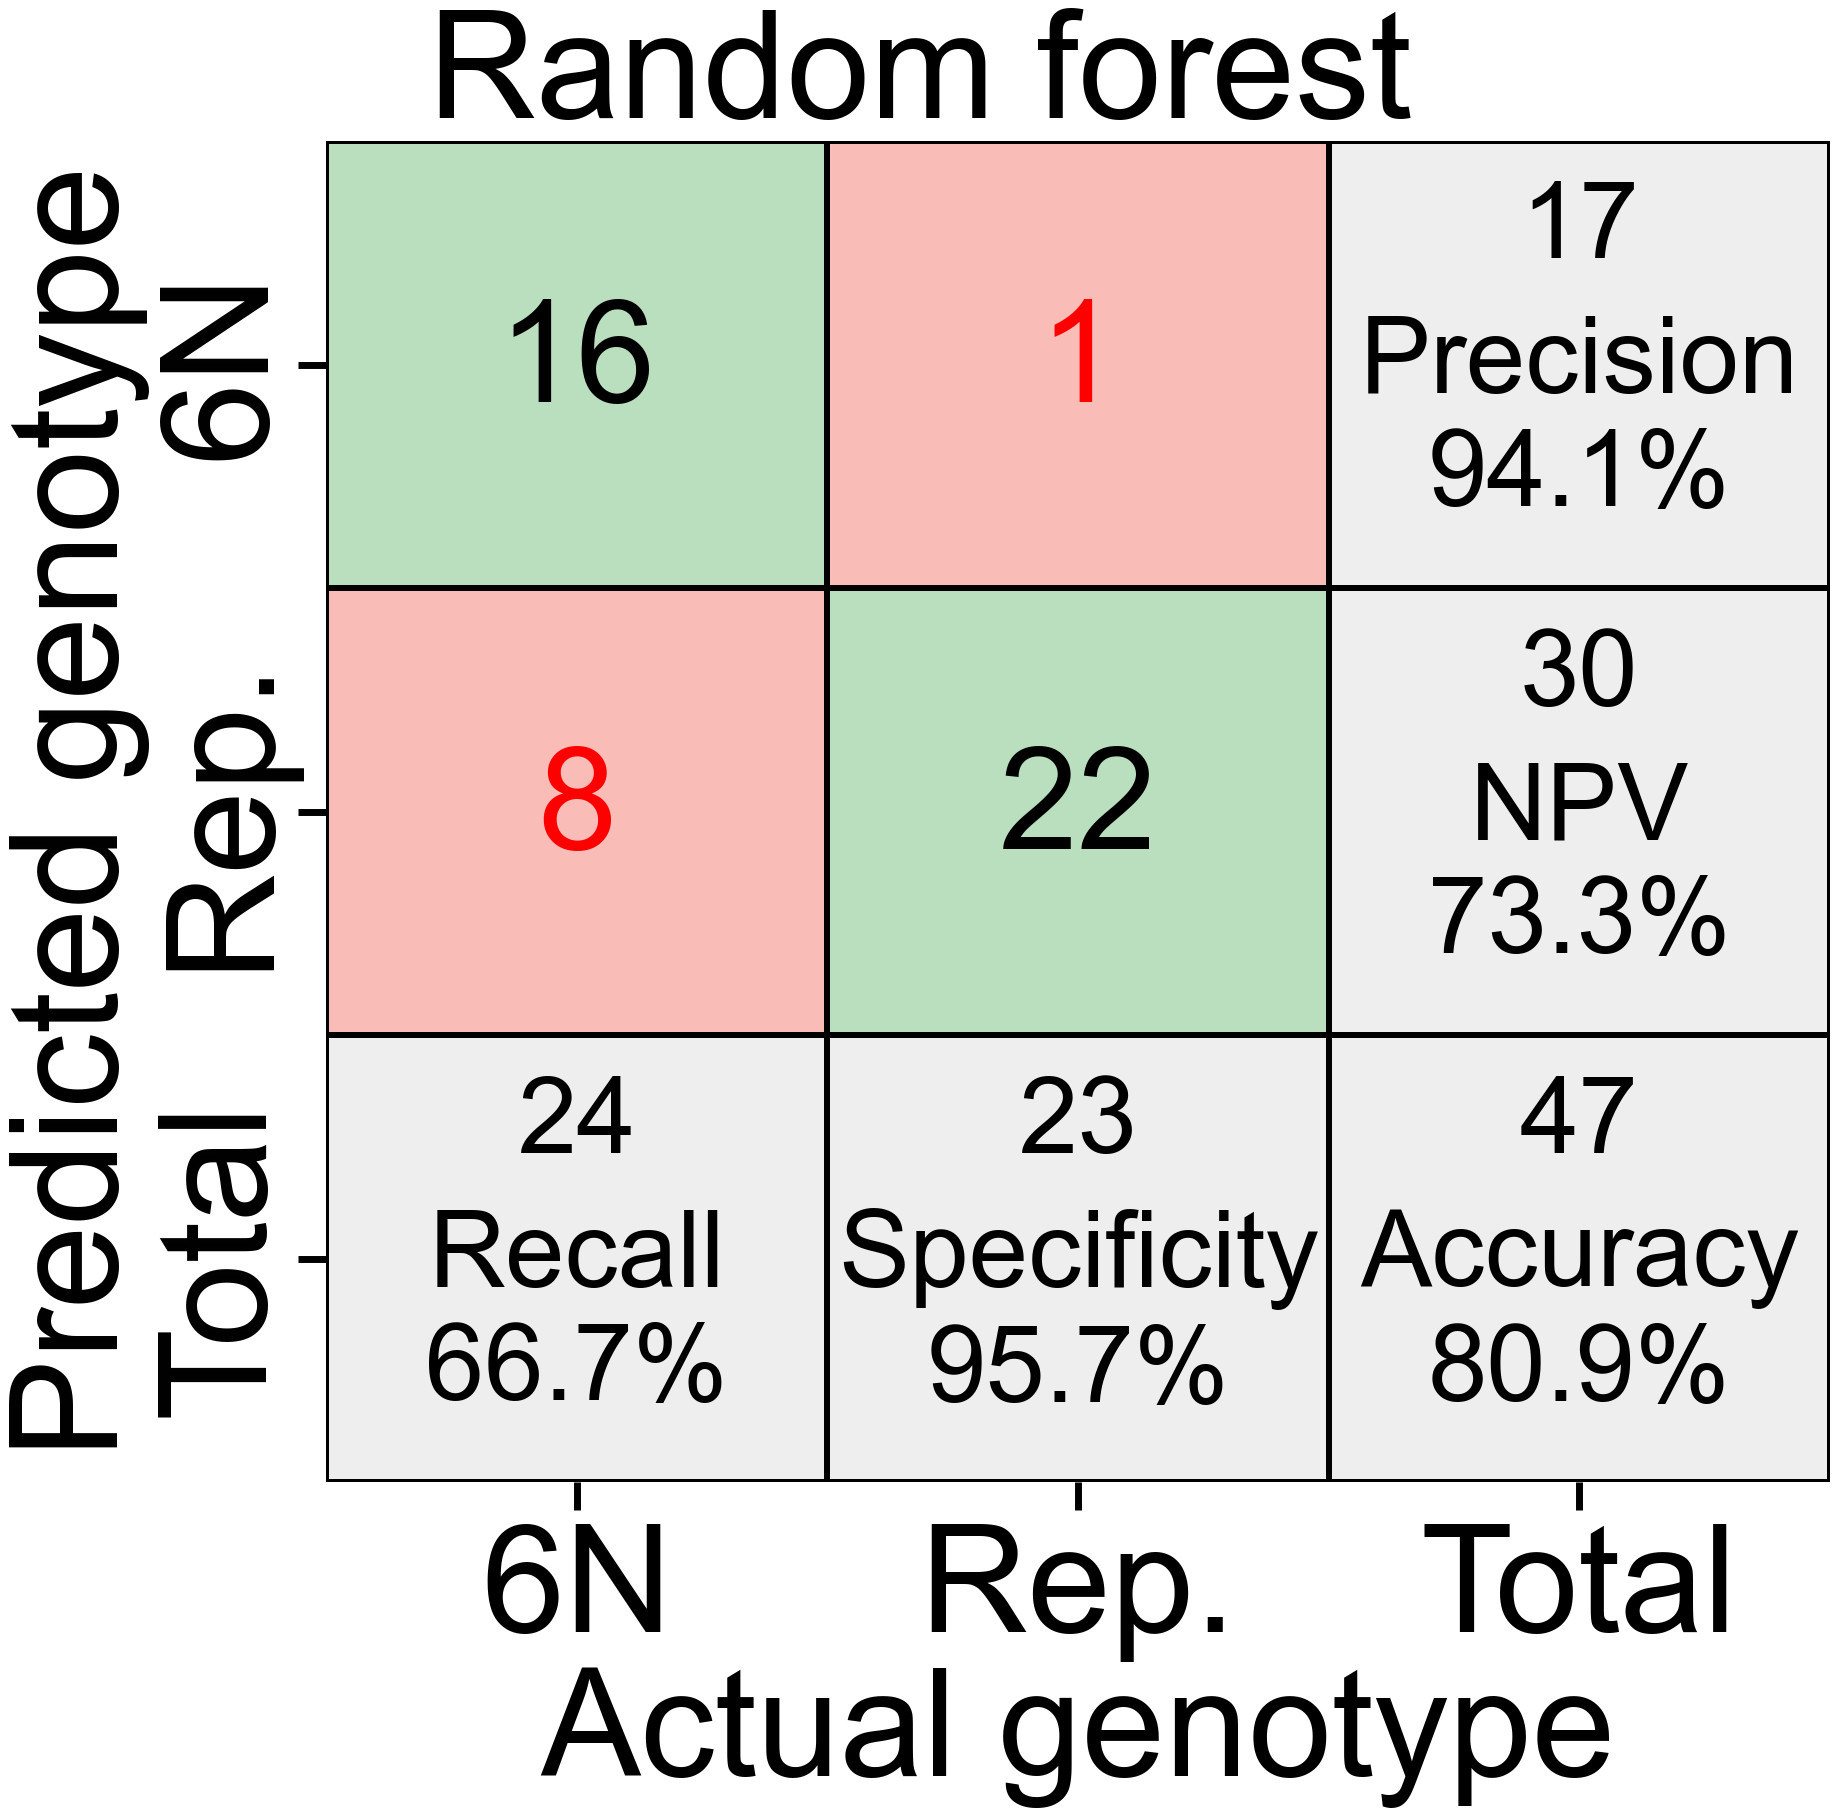

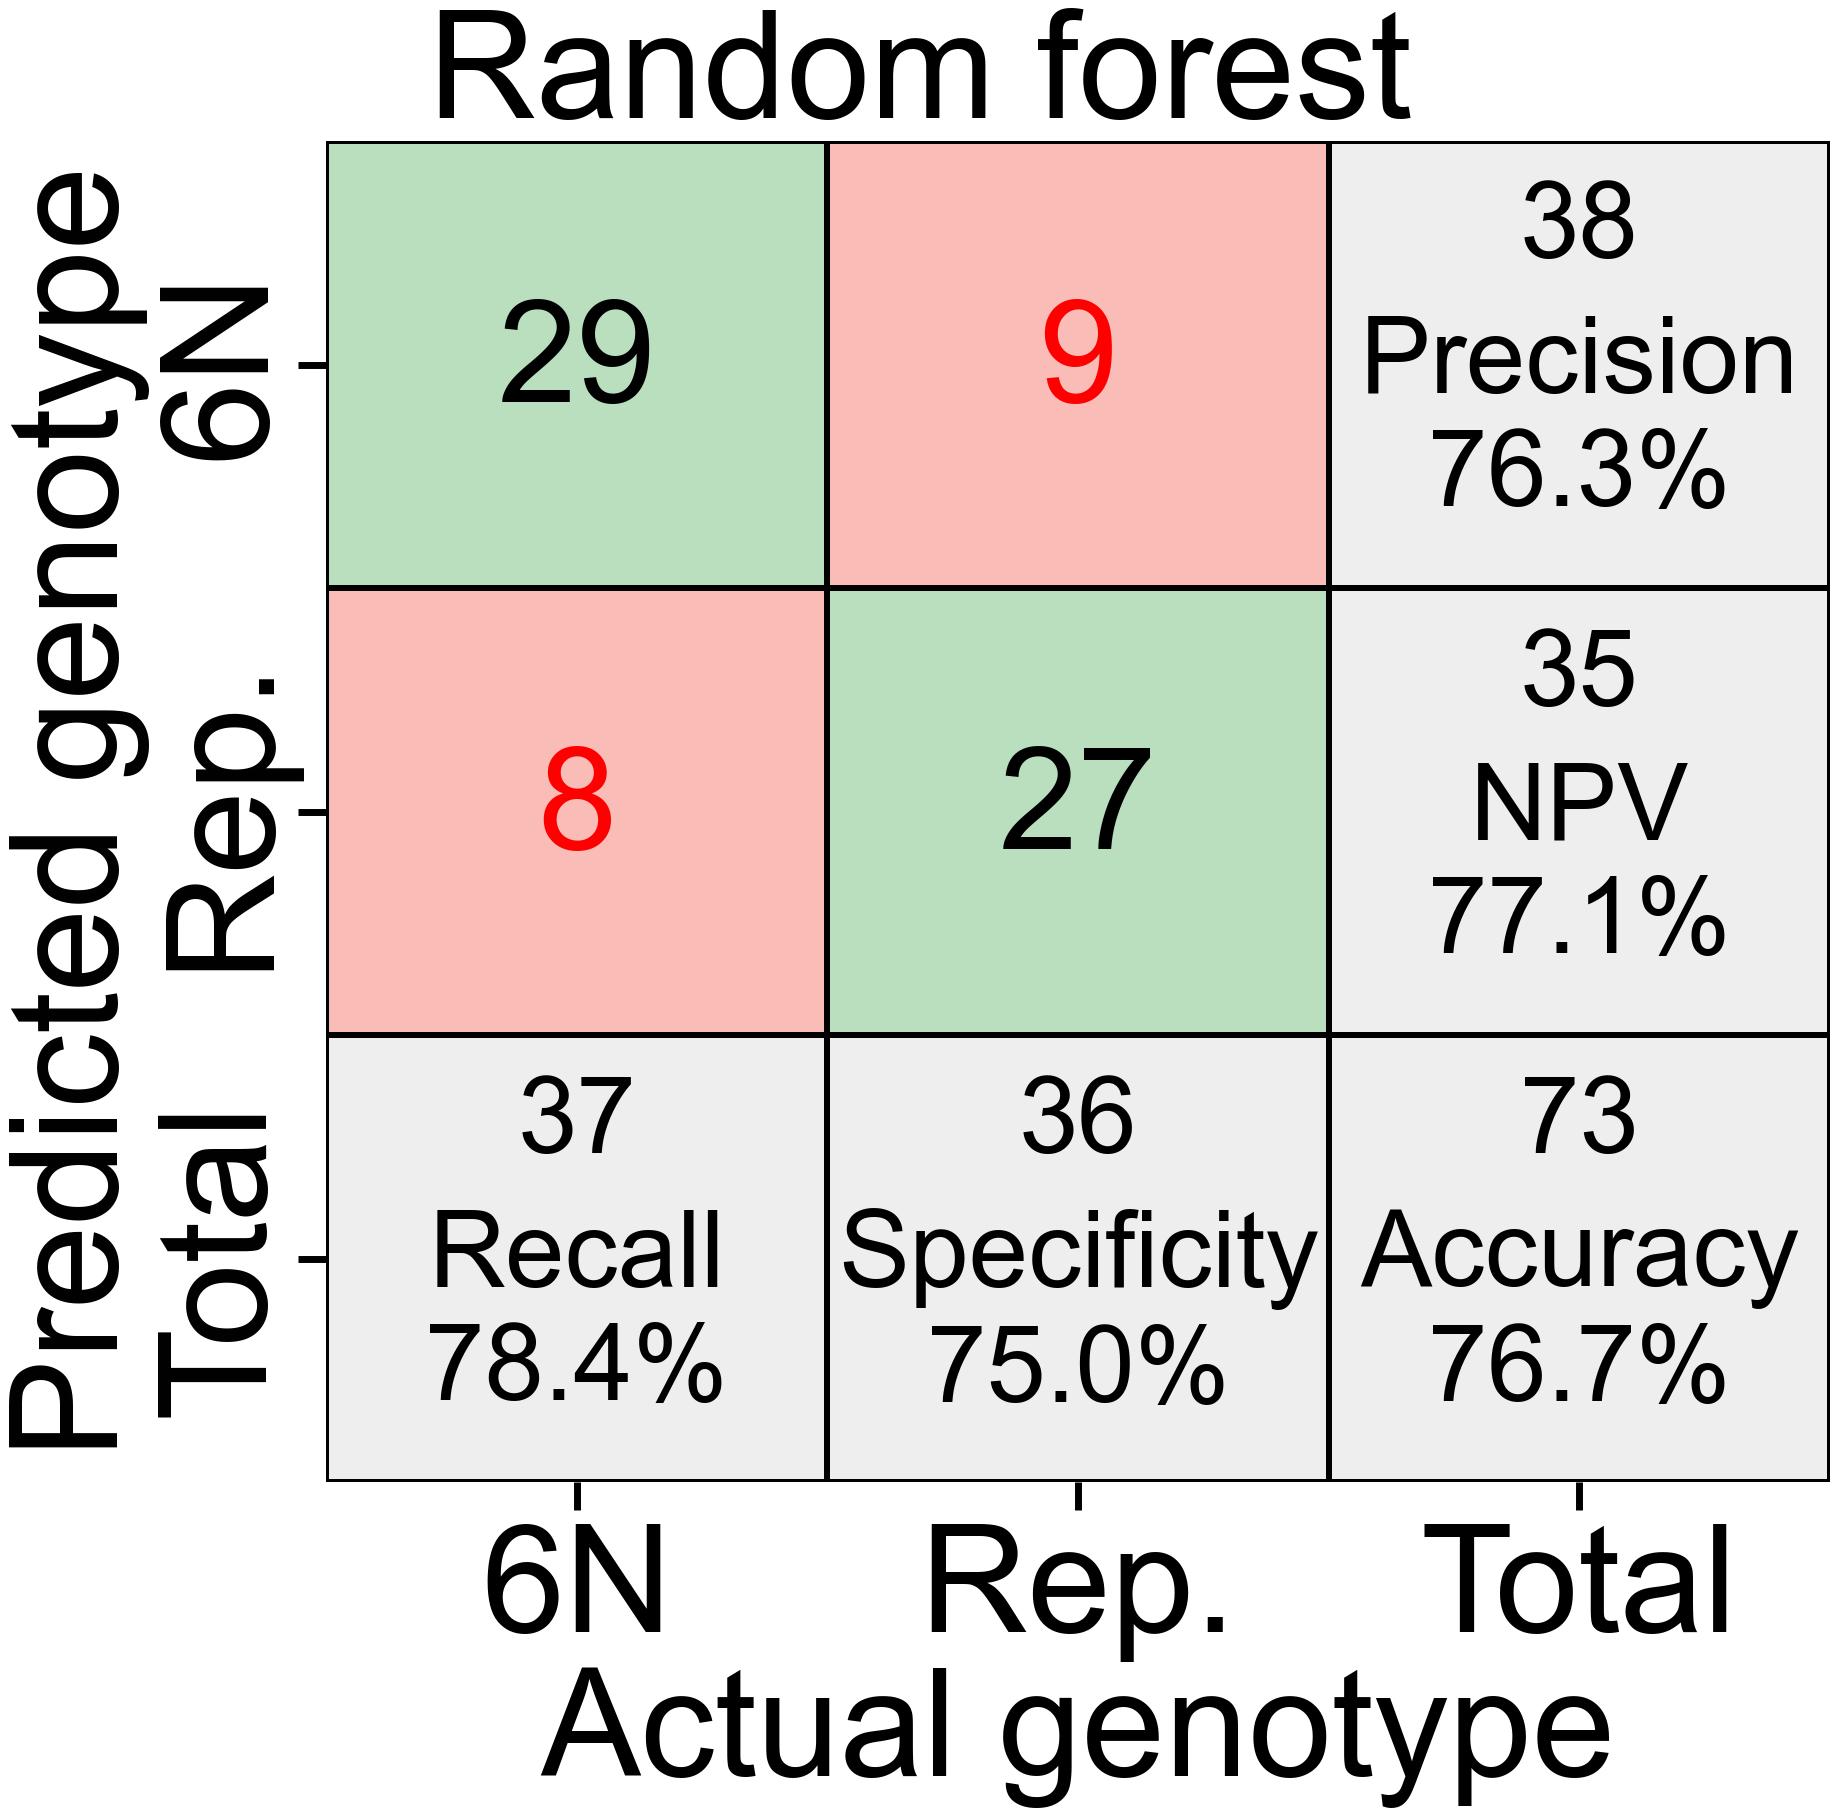

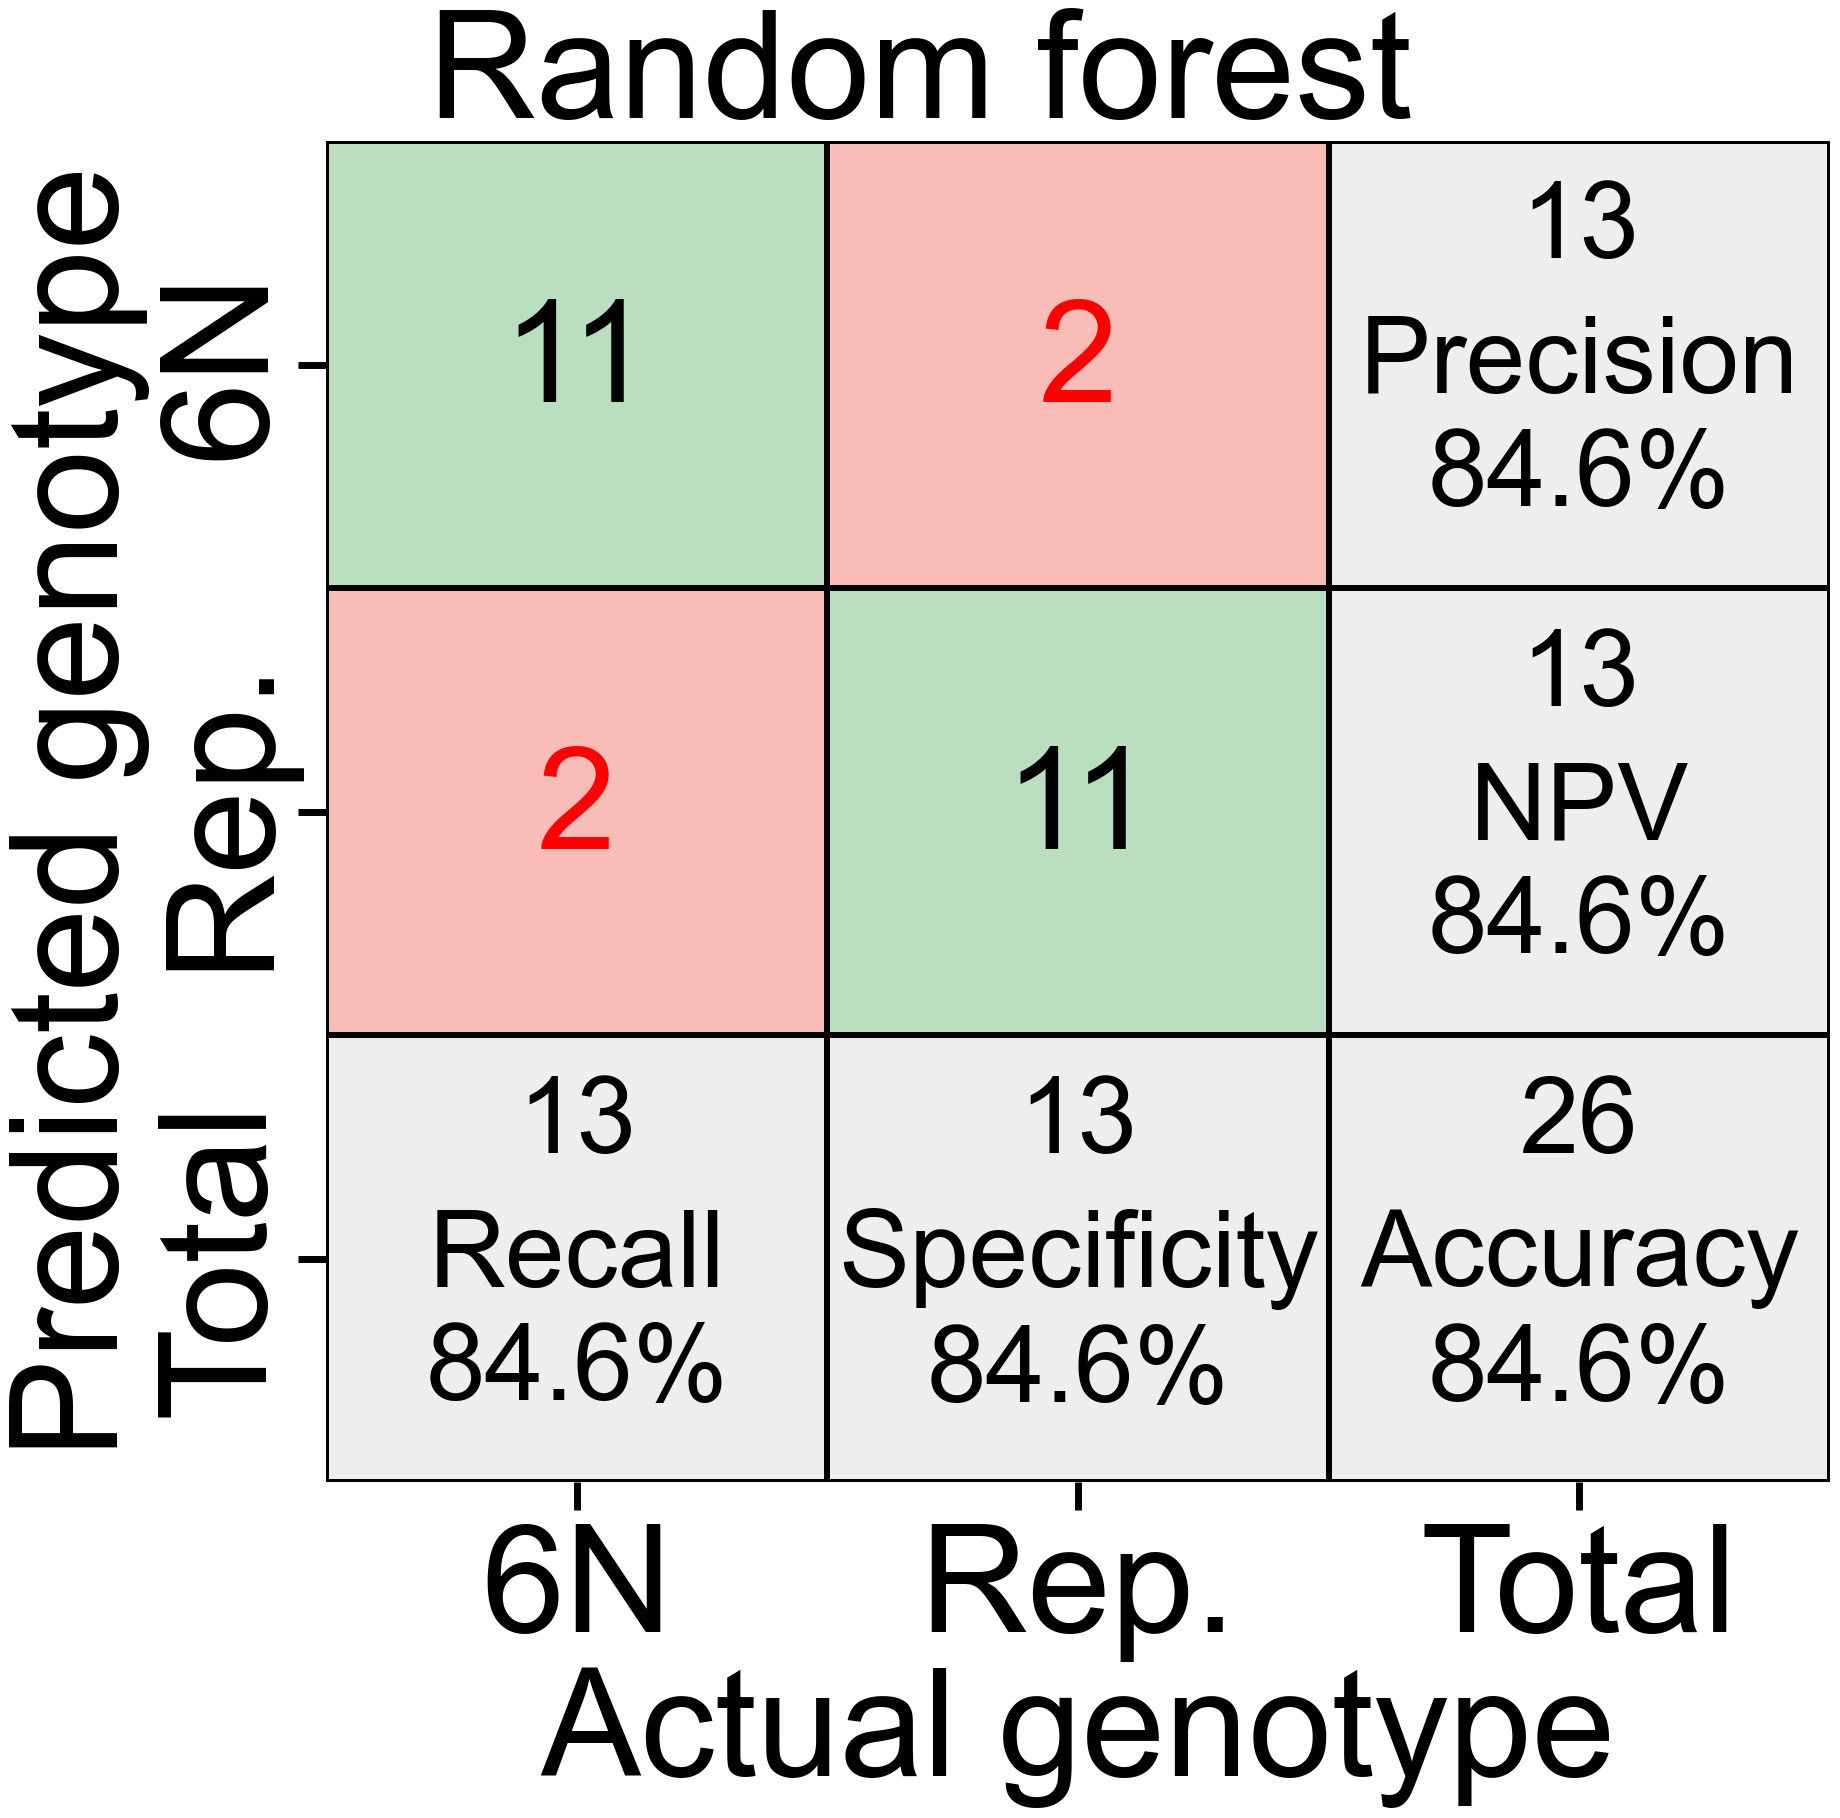

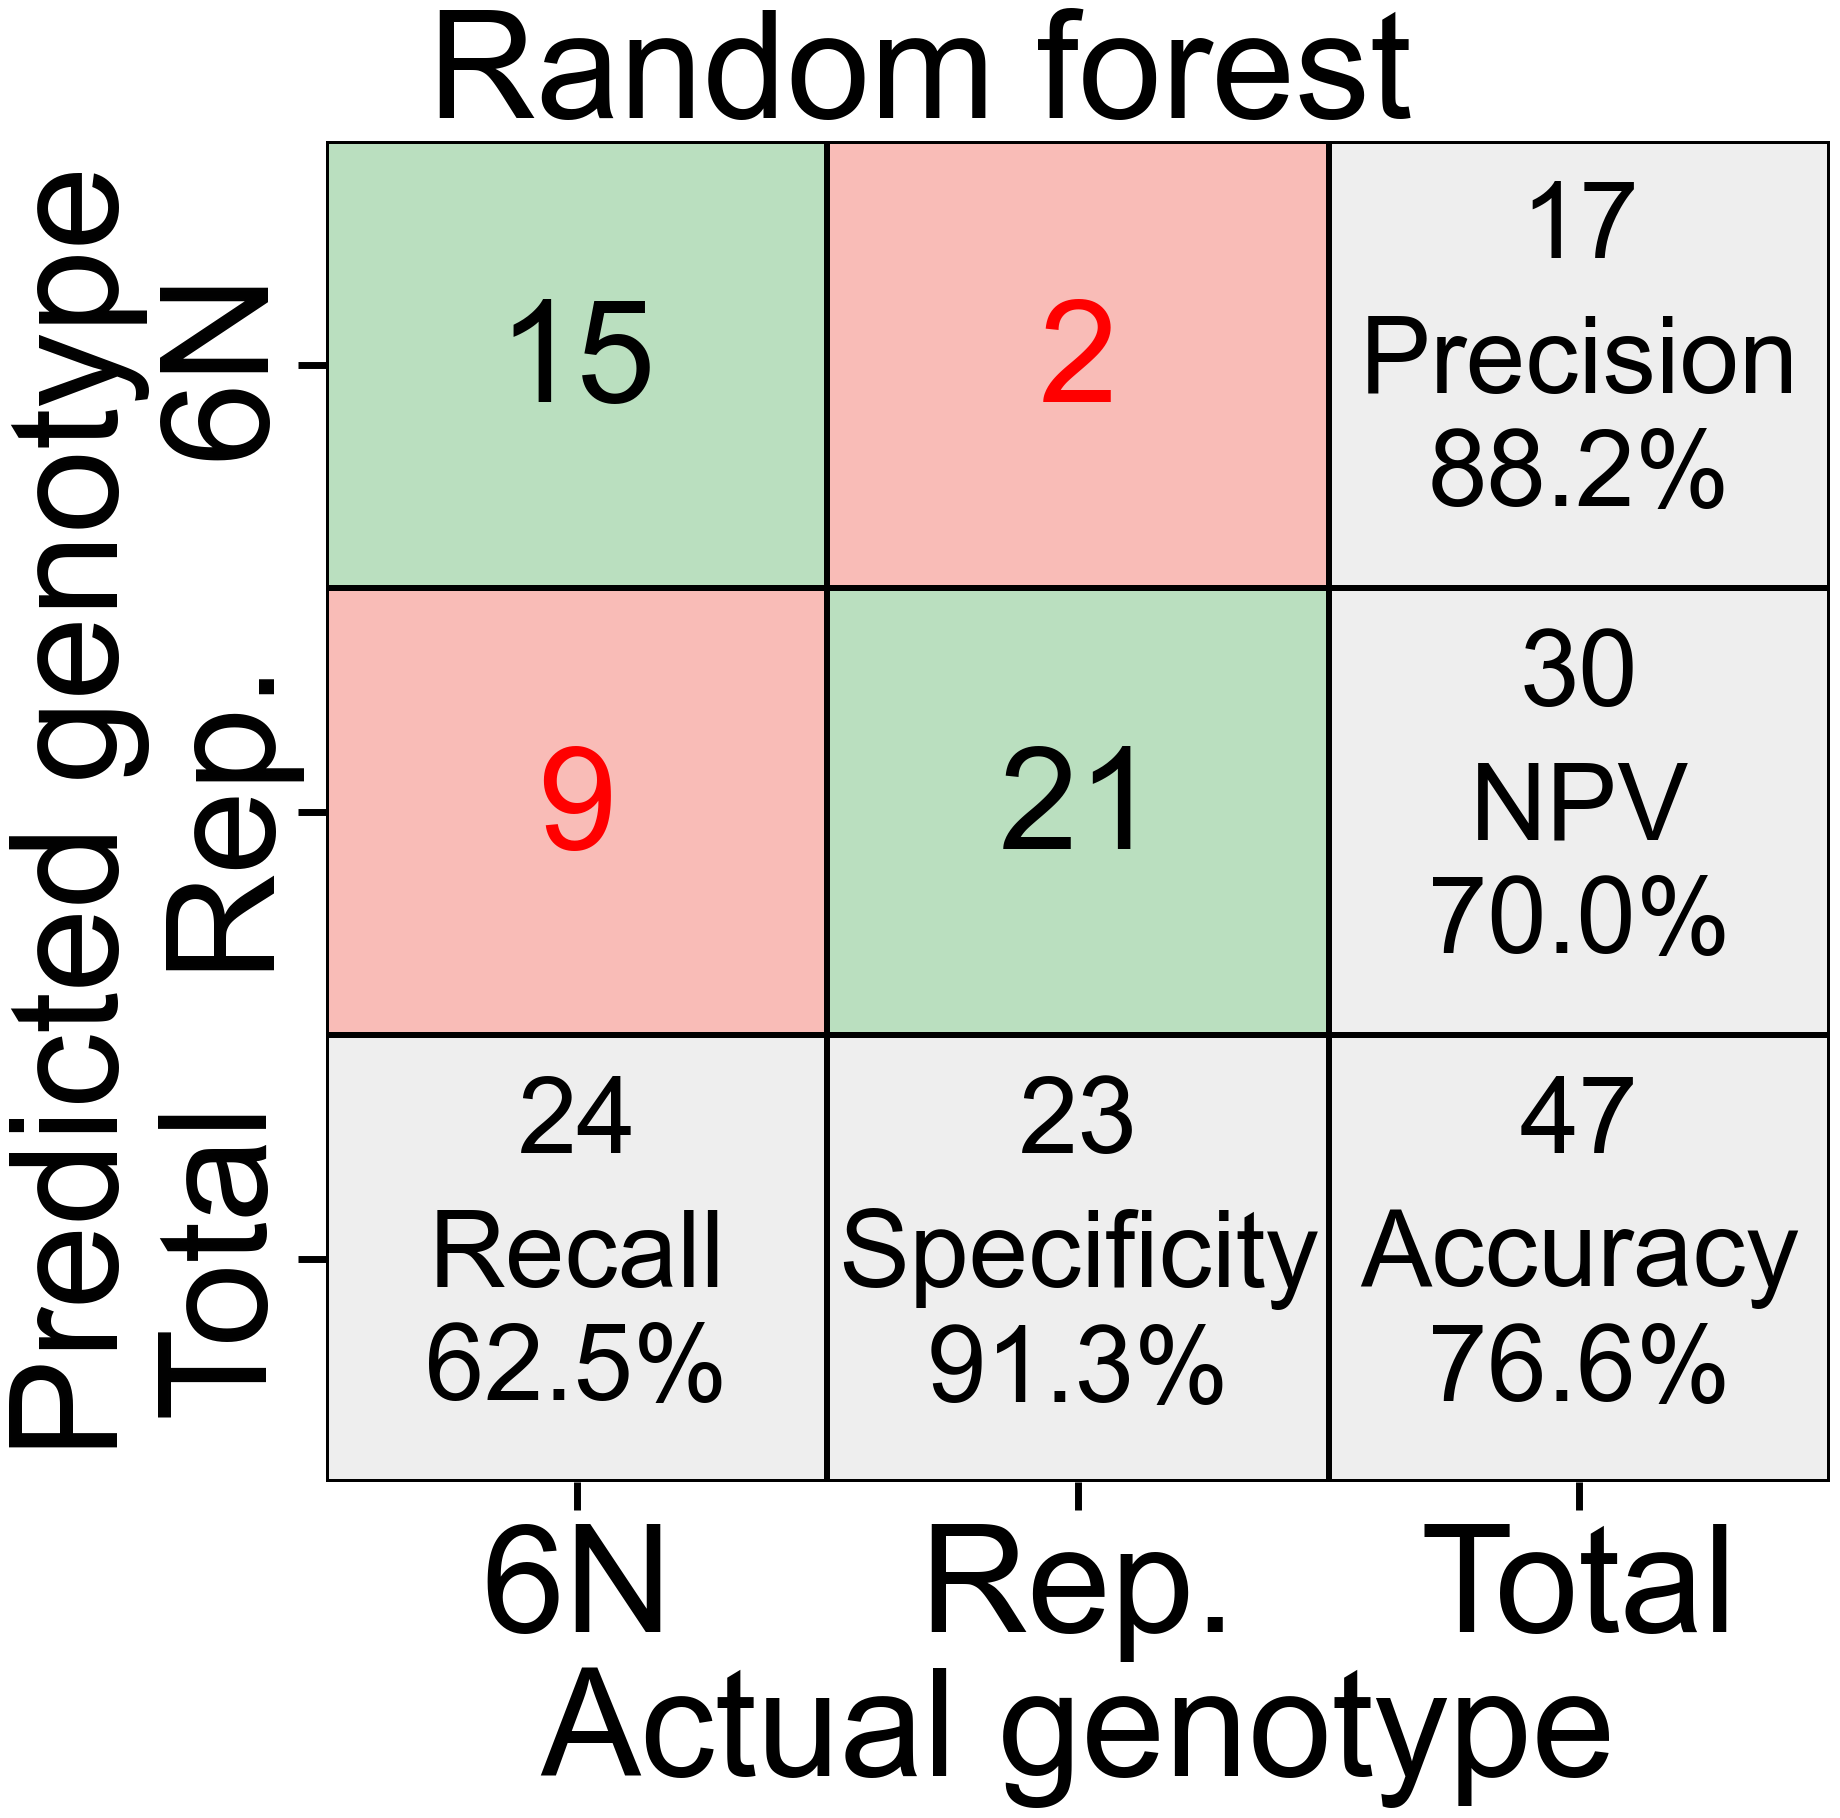

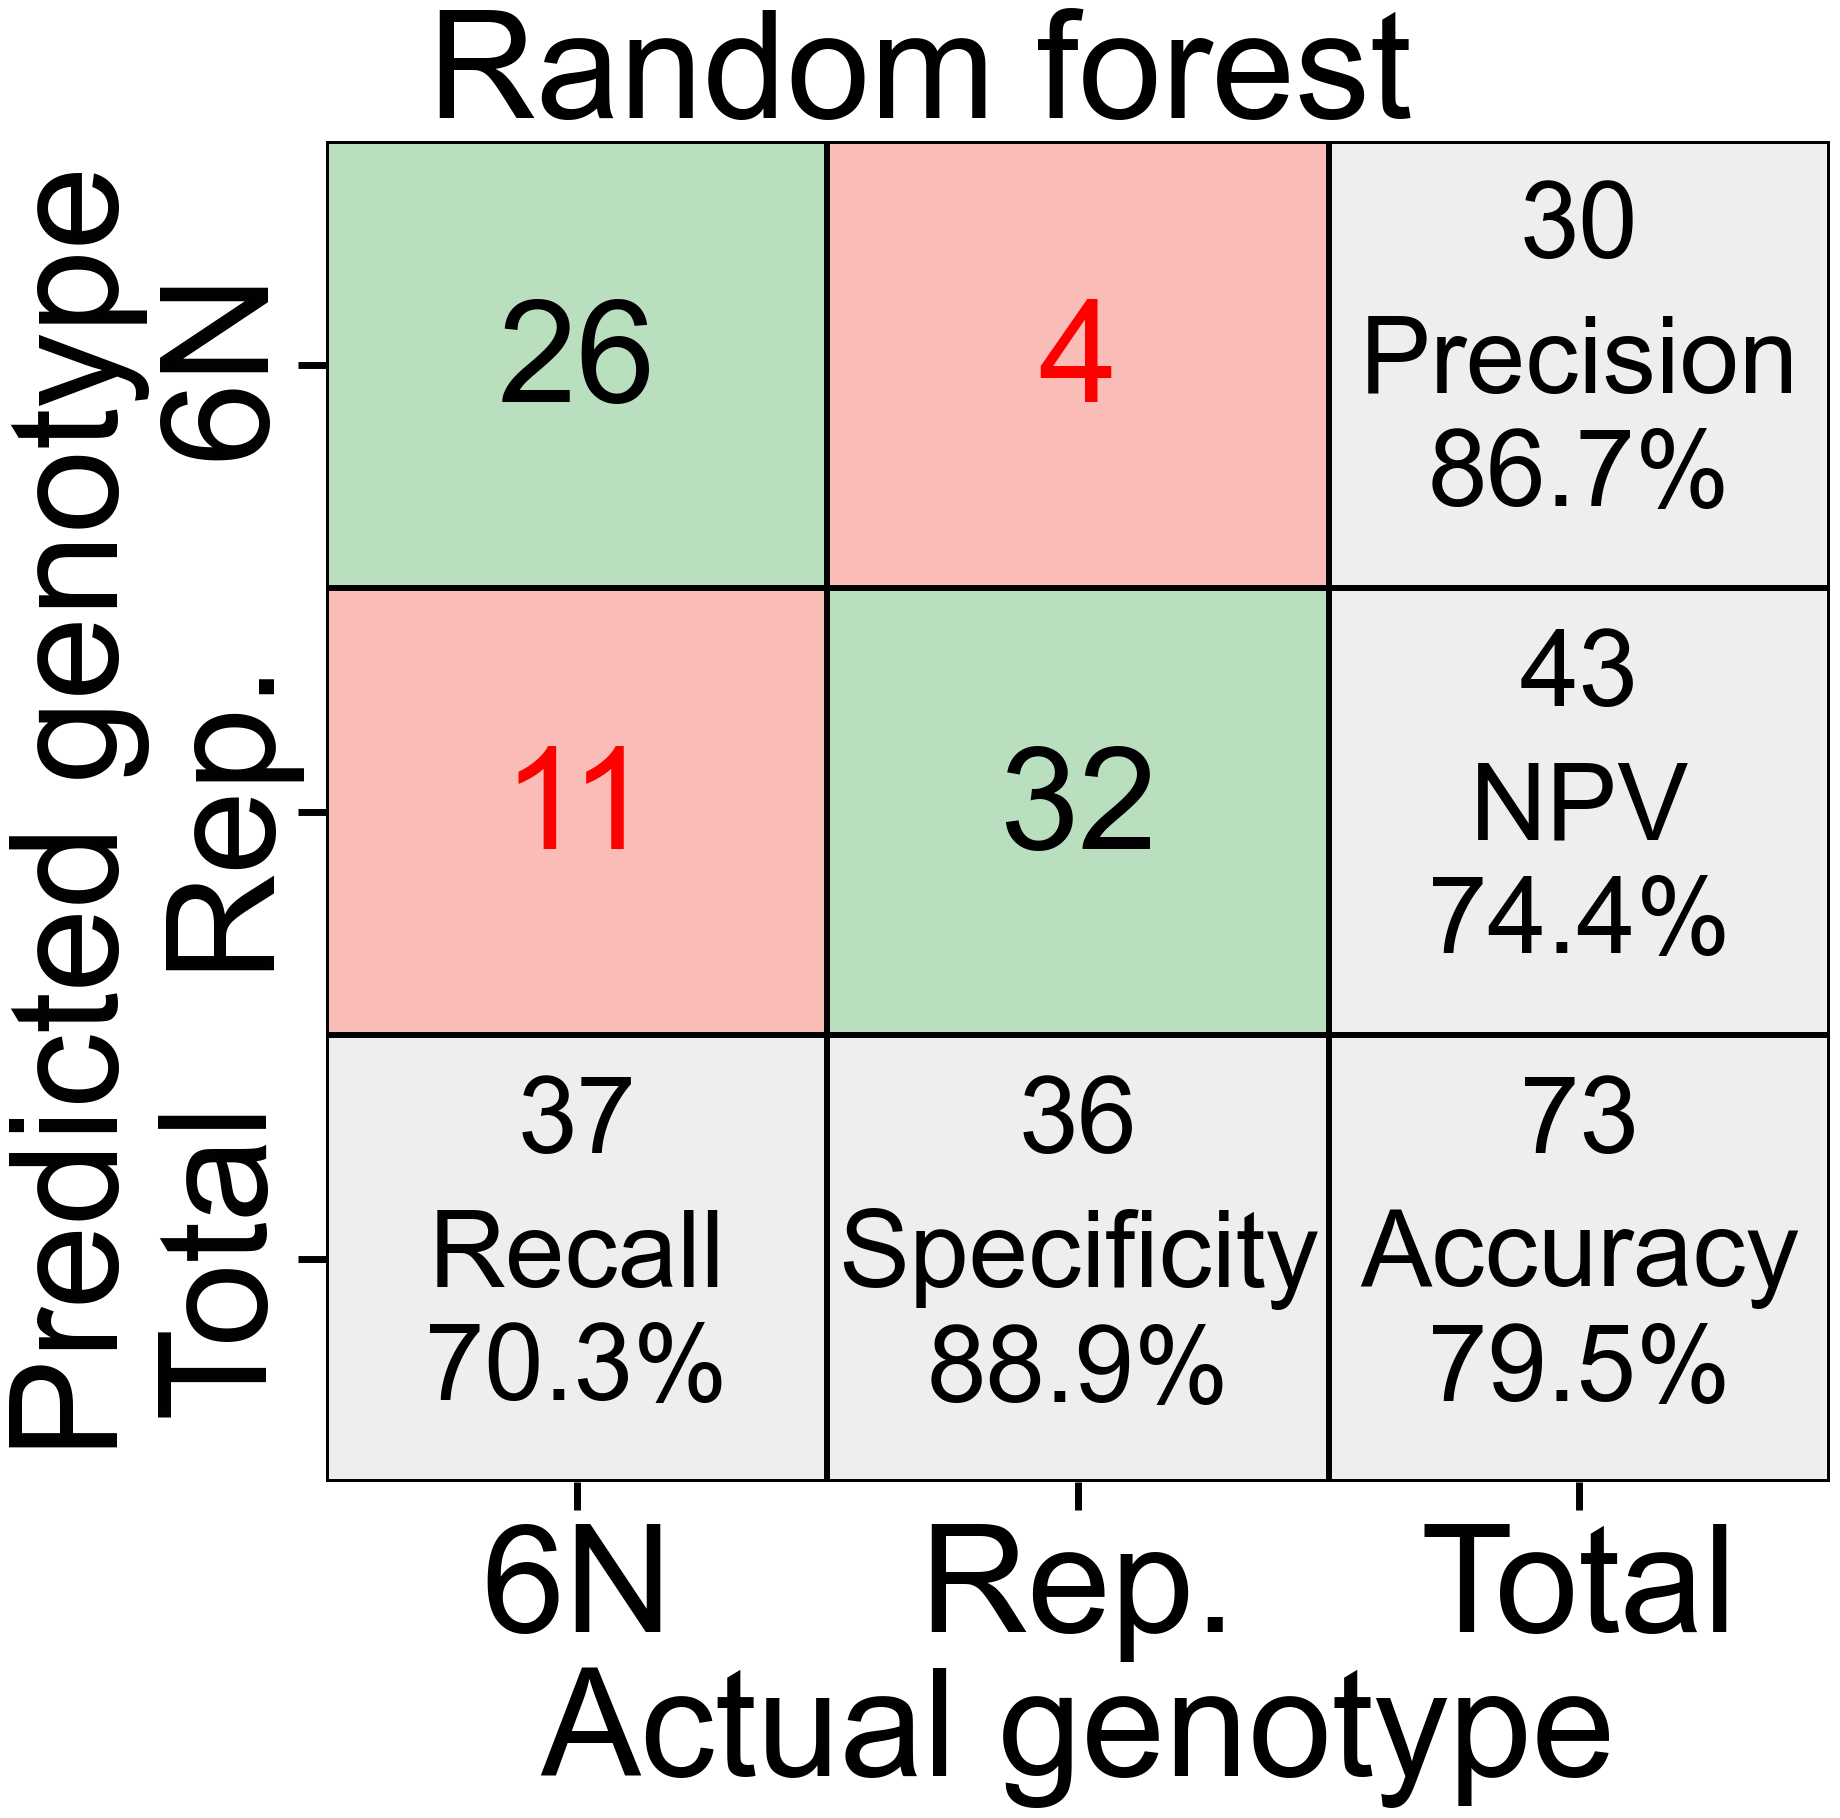

In [14]:
#Plot all confusion matrices 

models = ['forest','SVC','MLP','XGBOOST','rocket','hivecote']
training = ['Sheffield', 'Kings','Combined']
targets = ['Sheffield', 'Kings','Combined']
index = 0

for index in range(3):
    for model in [models[4]]:
        for target in targets:
            try:
                df = pd.read_csv(os.path.join(resultFolder,f'{model}{training[index]}_kFoldCrossValidation_AnovaFS10percentClicktestResults_{target}.csv'),index_col=0)
            except FileNotFoundError:
                try:
                    df = pd.read_csv(os.path.join(resultFolder,f'{model}{training[index]}_kFoldCrossValidation_AnovaFS10percentClicktestResults.csv'),index_col=0)
                except FileNotFoundError:
                    df = pd.read_csv(os.path.join(resultFolder,f'{model}{training[index]}_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
            y_test = df['y_test']
            y_predict = df['y_predict']
            fig = figureTools.makeConfMatrix(y_test,y_predict,f'',fontSize=fontSize,innerFontSize=54*1.9,figsize=(3.7*2.5*2,3.7*2.5*2))#train:{training[index]} test:{target}
            fig.savefig(f'./Panels/CM_model_target{target}training{training[index]}__non_scaled.pdf',dpi=1200)

# Shapley coefficients

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def makeFigureFeatureImportanceSingleKings(h1, h2, out, fi, title, thresholds=None, fig=None, axs=None, linecolor='k', cmap=plt.cm.inferno, columns=np.arange(9), figsize=np.array([15.8/3, 16.35]), titleColor='k', plotDB=True):
    """
    Create a figure from ABR trace data and feature importances.
    Parameters:
    h1 : array-like
        Array containing frequency values.
    h2 : array-like
        Array containing intensity values.
    out : array-like
        Output data to be plotted.
    fi : array-like
        Feature importance data.
    title : str
        Title of the figure.
    thresholds : array-like, optional
        Threshold values for plotting (default is None).
    fig : matplotlib.figure.Figure, optional
        Figure object to use for plotting (default is None).
    axs : array-like of matplotlib.axes.Axes, optional
        Axes objects to use for plotting (default is None).
    linecolor : str, optional
        Color of the lines to be plotted (default is 'k').
    cmap : matplotlib.colors.Colormap, optional
        Colormap to use for feature importance (default is plt.cm.inferno).
    columns : array-like, optional
        Columns to be used for plotting (default is np.arange(9)).
    figsize : array-like, optional
        Size of the figure (default is np.array([15.8/3, 16.35])).
    titleColor : str, optional
        Color of the title text (default is 'k').
    plotDB : bool, optional
        Whether to plot dB labels (default is True).
    Returns:
    fig : matplotlib.figure.Figure
        The created figure.
    axs : array-like of matplotlib.axes.Axes
        The axes of the created figure.
    """

    frequency = [h1[0]]#[100,3000,6000, 12000,18000,24000,30000,36000,42000 ]
    intensity = h2#arange(0,100,5)
    
    nint = len(intensity)
    
    nfreq=1
    freqmap=dict(zip(frequency,np.arange(len(frequency))))
    imap = dict(zip(intensity,np.arange(len(intensity))))

    ntraces = 153
    ppt = 1953 #points per trace
    

    if fig is None:
        fig,axs=plt.subplots(nint,nfreq,sharex=False, sharey=False,subplot_kw={'xticks': [], 'yticks': []},figsize=figsize)
    for i in range(len(intensity)):
        row = i#imap[int(h2[i])]

        #plotn = i+row*len(frequency)
        linecol = linecolor


        axs[nint-row-1].plot(out[i,2:],c=linecol,linewidth=2)

        if nint-row-1==0:
            tit1 = int(h1[i])

            if tit1 == 100:
                tit='Click'
            else:
                tit = str(int(tit1/1000))+' kHz'
            axs[nint-row-1].set_title(tit,fontsize=fontSize*0.55,ha='center')
        
        
        #axs[nint-row-1].set_ylabel(str(int(h2[i]))+' dB')
    
    

    for row in range(nint):
        tr = fi[(nint-1-row)*ppt:(nint-row)*ppt]
        currAx = row
        ax = fig.axes[currAx]
        divider = make_axes_locatable(ax)

        ax2 = divider.append_axes("bottom", size="100%", pad=-0.1, sharex=ax)
        #ax2.plot(tr,'r')
       # ax2.set_ylim(fi.min(),fi.max())
        ax2.imshow(tr.reshape((1,-1)),aspect=50,cmap=cmap,vmin=fi.min(),vmax=max(fi),alpha=1,interpolation='None')
        
            
    # ylims=(0,100)
    # for i in range(20,37):
    #     ax = fig.axes[i]
    #     ax.set_ylim(-0.1,0.1)
    #     ax.axis('off')
    
    plt.tight_layout()   
    for i in range(0,len(intensity)*2):
        ax = fig.axes[i]
    # ax.set_ylim(-4.5,7)
        ax.axis('off')
        ax.set_xlim(0,10*fs/1000)
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=0.05,hspace=0)


    #fig.text(0.08,0.95,'95',fontsize=28, rotation = 0,va='center',ha='center')fontsize=28*1.5
    if plotDB:
        fig.text(0.08,0.98,'dB',fontsize=fontSize*0.45, rotation = 0,va='center',ha='center')
        step = (0.97-0.051)/nint*1.03
        for i in range(nint):
            fig.text(0.08,0.051+i*step,f'{15+5*i}',fontsize=fontSize*0.45, rotation = 0,va='center',ha='center')

    fig.suptitle(title,y=1.015,fontsize=fontSize*0.45,weight='bold',color = titleColor)
    

    return fig,axs

In [19]:
from abrTools import loadKingsData, loadSheffieldData,interFunc


# Kings Feature importances plot

/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Repaired' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kingsData.loc[kingsData['Status']=='Ahl-Repaired','Strain']='Repaired'


'[(100, 75), (100, 80), (100, 85)] not in index'
1
'[(100, 85)] not in index'
2
'[(100, 85)] not in index'
3
'[(100, 85)] not in index'
4
'[(100, 80), (100, 85)] not in index'
5
'[(100, 75), (100, 80), (100, 85)] not in index'
6


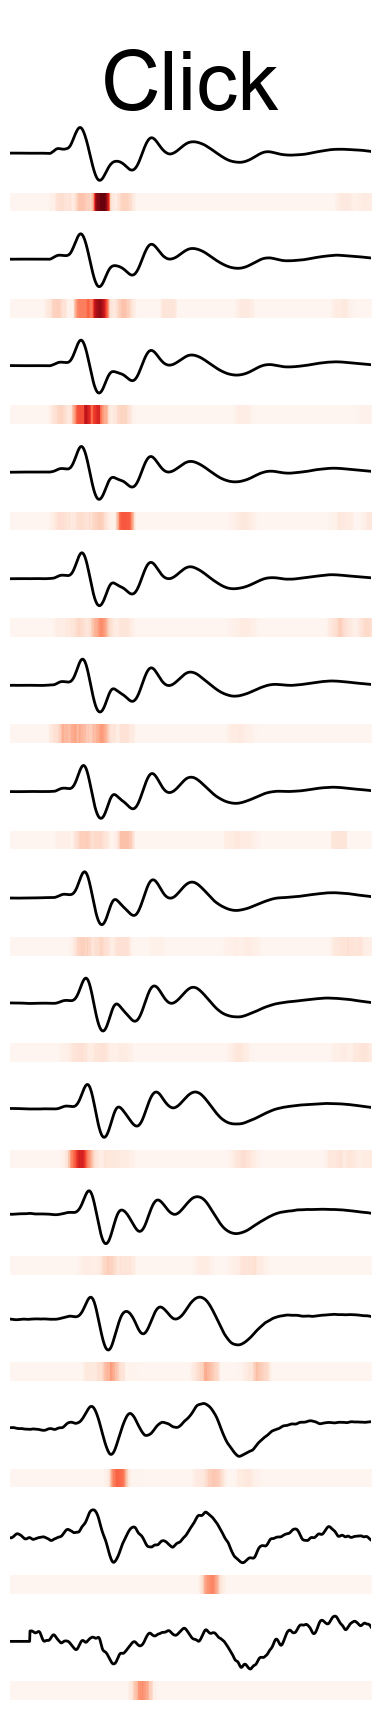

In [20]:
import joblib
savgolFilterOrder = 41
cmap = cm.Reds

resultFolder =  '../../results/2024-10-27-sheffieldvKings-unscaled'

X_kings_train,X_kings_test,y_kings_train,y_kings_test,X_kings,y_kings = loadKingsData(shift=54,scaling=False,filename='../../data/Kings - MAchineLEarningABR_ExperimentList.xlsx',
                                                                                     dataFolder='../../data')
X = X_kings.mean(0)
X = pad(X,[54,0])
X = X.reshape(int(X.size/1953),1953)
h1 = array([100]*15)
h2 = arange(15,90,5)

#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forestKings_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)

fi2 = pd.read_csv(os.path.join(resultFolder,'XGBOOSTKings_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)

fi3 = pd.read_csv(os.path.join(resultFolder,'SVCKings_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)

# fi4 = pd.read_csv(os.path.join(resultFolder,'MLPKings_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
# fi4 = abs(fi3).mean(1).values
# fi4 = savgol_filter(fi4,savgolFilterOrder,1)

fi = (fi/fi.max()+fi2/fi2.max()+fi3/fi3.max())/3
fi = pad(fi,[54,0])
fig,axs = makeFigureFeatureImportanceSingleKings(h1,h2,np.hstack((h1.reshape(-1,1),h2.reshape(-1,1),X)),fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3.5 ,  17]),
                                                 titleColor = np.array([59,117,175])/255,plotDB=False)

fig.savefig('./Panels/ShapleyKingsVSheffield_Set2_Click_unscaled.pdf',dpi=1200,transparent=True)

# Sheffield feature importances plot

The dataset version is: 20230914 - V41
Counter({'Repaired': 54, '6N': 50})


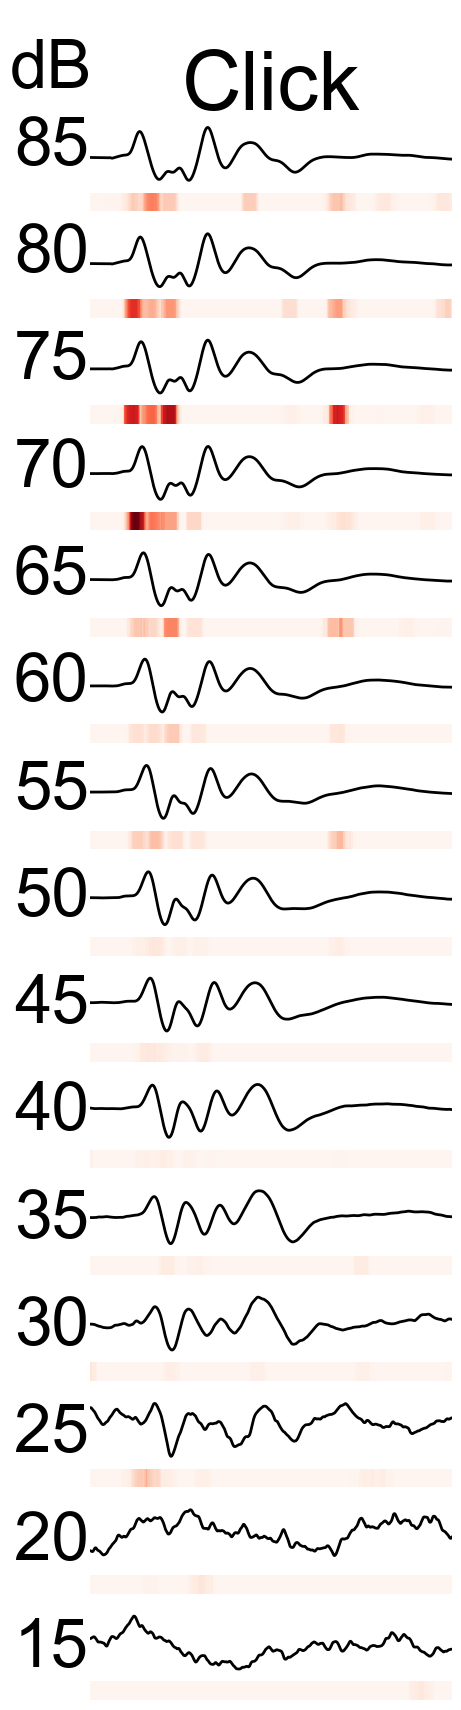

In [23]:
X_train_Sheffield,X_test_Sheffled,y_train_Sheffield,y_test_Sheffield,X_full,y_full, dataVersion = loadSheffieldData(shift=54,dataFolder='../../data')
X = X_full.mean(0)
X = pad(X,[0,54])
X = X.reshape(int(X.size/1953),1953)
h1 = array([100]*15)
h2 = arange(15,90,5)

#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forestSheffield_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)

fi2 = pd.read_csv(os.path.join(resultFolder,'XGBOOSTSheffield_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)

fi3 = pd.read_csv(os.path.join(resultFolder,'SVCSheffield_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)


fi = (fi/fi.max()+fi2/fi2.max()+fi3/fi3.max())/3
fi = pad(fi,[0,54])
fig,axs = makeFigureFeatureImportanceSingleKings(h1,h2,np.hstack((h1.reshape(-1,1),h2.reshape(-1,1),X)),fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3.5 ,  17]),
                                                  titleColor = np.array([239,134,54])/255,plotDB=True)
fig.savefig('./Panels/ShapleyKingsVSheffield_Set1_Click_unscaled.pdf',dpi=1200,transparent=True)

# Combined feature importances plot 

/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/../../src/abrTools.py:1499: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Repaired' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kingsData.loc[kingsData['Status']=='Ahl-Repaired','Strain']='Repaired'


'[(100, 75), (100, 80), (100, 85)] not in index'
1
'[(100, 85)] not in index'
2
'[(100, 85)] not in index'
3
'[(100, 85)] not in index'
4
'[(100, 80), (100, 85)] not in index'
5
'[(100, 75), (100, 80), (100, 85)] not in index'
6
The dataset version is: 20230914 - V41
Counter({'Repaired': 54, '6N': 50})


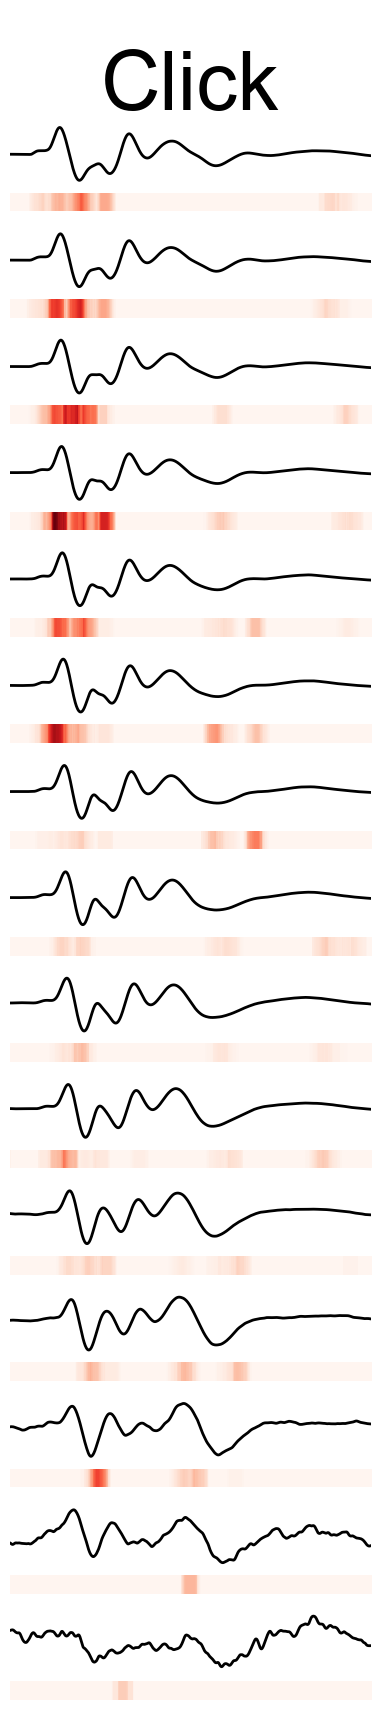

In [25]:
X_kings_train,X_kings_test,y_kings_train,y_kings_test,X_kings,y_kings = loadKingsData(shift=54,scaling=False,filename='../../data/Kings - MAchineLEarningABR_ExperimentList.xlsx',
                                                                                     dataFolder='../../data')

X_train_Sheffield,X_test_Sheffled,y_train_Sheffield,y_test_Sheffield,X_full,y_full, dataVersion = loadSheffieldData(shift=54,dataFolder='../../data')


X_train = np.vstack((X_train_Sheffield,X_kings_train))
X_test = np.vstack((X_test_Sheffled,X_kings_test))
y_train = np.hstack((y_train_Sheffield, y_kings_train))
y_test = np.hstack((y_test_Sheffield, y_kings_test))

X_combined = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))


X = X_combined.mean(0)
X = pad(X,[0,54])
X = X.reshape(int(X.size/1953),1953)
h1 = array([100]*15)
h2 = arange(15,90,5)


#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forestCombined_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)

fi2 = pd.read_csv(os.path.join(resultFolder,'XGBOOSTCombined_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)

fi3 = pd.read_csv(os.path.join(resultFolder,'SVCCombined_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)

# fi4 = pd.read_csv(os.path.join(resultFolder,'MLPCombined_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
# fi4 = abs(fi3).mean(1).values
# fi4 = savgol_filter(fi4,savgolFilterOrder,1)

fi = (fi/fi.max()+fi2/fi2.max()+fi3/fi3.max())/3
fi = pad(fi,[0,54])

fig,axs = makeFigureFeatureImportanceSingleKings(h1,h2,np.hstack((h1.reshape(-1,1),h2.reshape(-1,1),X)),fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3.5 ,  17]),
                                               titleColor =  np.array([81,158,62])/255,plotDB=False)

fig.savefig('./Panels/ShapleyKingsVSheffield_Combined_Click_unscaled.pdf',dpi=1200,transparent=True)